Data fields:

Access_ID - Unique identification of the user access to the website

Date - Website visit date

AccountMng_Pages - Number of pages visited by the user about account management

AccountMng_Duration - Total amount of time (seconds) spent by the user on account management related pages

FAQ_Pages - Number of pages visited by the user about frequently asked questions, shipping information and company related pages

FAQ_Duration - Total amount of time (seconds) spent by the user on FAQ pages

Product_Pages - Number of pages visited by the user about products and services offered by the company

Product_Duration - Total amount in time (seconds) spent by the user on products and services related pages

GoogleAnalytics_BounceRate - Average bounce rate value of the pages visited by the user, provided by google analytics

GoogleAnalytics_ExitRate - Average exit rate value of the pages visited by the user, provided by google analytics

GoogleAnalytics_PageValue - Average page value of the pages visited by the user, provided by google analytics

OS - Operating System of the user

Browser - Browser used to access the webpage

Country - The country of the user

Type_of_Traffic - Traffic Source by which the user has accessed the website (e.g., email, banner, direct)

Type_of_Visitor - User type as "New access", "Returner" or "Other"

Buy - Class label indicating if the user finalized their actions in the website with a transaction

In [82]:
import pandas as pd
import numpy as np
import datetime
from math import ceil

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.feature_selection import mutual_info_classif

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.linear_model import LogisticRegression, RidgeClassifier

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

from sklearn import metrics

In [137]:
model_metrics = pd.DataFrame(columns=['Precision','Recall','F1 Score'])

In [2]:
# importing datasets
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
# sub_smp = pd.read_csv('../data/sample_submission.csv')

In [3]:
# set access ID as index
df_train.set_index('Access_ID', inplace = True)

In [4]:
round(df_train.Buy.mean(),3)*100 # we have an average conversion rate of 15.5%

15.5

In [5]:
# from object to date
df_train.Date = df_train.Date.apply(lambda x: datetime.datetime.strptime(x, "%d-%b-%y"))

In [6]:
#confirm
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 102863333 to 798444008
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        9999 non-null   datetime64[ns]
 1   AccountMng_Pages            9999 non-null   int64         
 2   AccountMng_Duration         9999 non-null   float64       
 3   FAQ_Pages                   9999 non-null   int64         
 4   FAQ_Duration                9999 non-null   float64       
 5   Product_Pages               9999 non-null   int64         
 6   Product_Duration            9999 non-null   float64       
 7   GoogleAnalytics_BounceRate  9999 non-null   float64       
 8   GoogleAnalytics_ExitRate    9999 non-null   float64       
 9   GoogleAnalytics_PageValue   9999 non-null   float64       
 10  OS                          9999 non-null   object        
 11  Browser                     9999 non-null  

### Data Partition

In [7]:
X = df_train.drop(['Buy'],axis=1)
y = df_train['Buy']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
print(X_train.shape)
print(X_test.shape)

(7999, 15)
(2000, 15)


In [13]:
print(round(y_train.mean(),3))
print(round(y_test.mean(),3))

0.155
0.155


### Data Exploration

In [14]:
X_train.head().T

Access_ID,579558156,317781105,607317379,474356679,487584836
Date,2020-12-06 00:00:00,2020-11-30 00:00:00,2020-03-31 00:00:00,2020-12-26 00:00:00,2020-10-13 00:00:00
AccountMng_Pages,0,0,0,1,0
AccountMng_Duration,0.0,0.0,0.0,6.5,0.0
FAQ_Pages,0,0,0,0,0
FAQ_Duration,0.0,0.0,0.0,0.0,0.0
Product_Pages,7,40,14,10,4
Product_Duration,121.0,974.0833,363.3182,511.25,741.4
GoogleAnalytics_BounceRate,0.0286,0.0068,0.0143,0.0,0.05
GoogleAnalytics_ExitRate,0.0571,0.0282,0.0238,0.0074,0.075
GoogleAnalytics_PageValue,0.0,0.0,0.0,7.8485,0.0


In [15]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
AccountMng_Pages,7999.0,2.353544,3.326227,0.0,0.00000,1.0000,4.0000,26.0000
AccountMng_Duration,7999.0,81.972139,181.245915,0.0,0.00000,10.0000,94.4250,3398.7500
FAQ_Pages,7999.0,0.507188,1.283093,0.0,0.00000,0.0000,0.0000,24.0000
FAQ_Duration,7999.0,34.313255,139.391466,0.0,0.00000,0.0000,0.0000,2549.3750
Product_Pages,7999.0,31.978122,44.672363,0.0,7.00000,18.0000,38.0000,705.0000
Product_Duration,7999.0,1210.607266,1983.632685,0.0,183.65835,607.5000,1495.0405,63973.5222
GoogleAnalytics_BounceRate,7999.0,0.021883,0.048271,0.0,0.00000,0.0031,0.0167,0.2000
GoogleAnalytics_ExitRate,7999.0,0.042847,0.048394,0.0,0.01430,0.0250,0.0500,0.2000
GoogleAnalytics_PageValue,7999.0,5.978653,18.937596,0.0,0.00000,0.0000,0.0000,361.7637
Browser,7999.0,2.347668,1.706750,1.0,2.00000,2.0000,2.0000,13.0000


In [16]:
X_train.describe(include=['O']).T

,count,unique,top,freq
OS,7999,8,Windows,4314
Country,7999,9,Portugal,3079
Type_of_Visitor,7999,3,Returner,6821


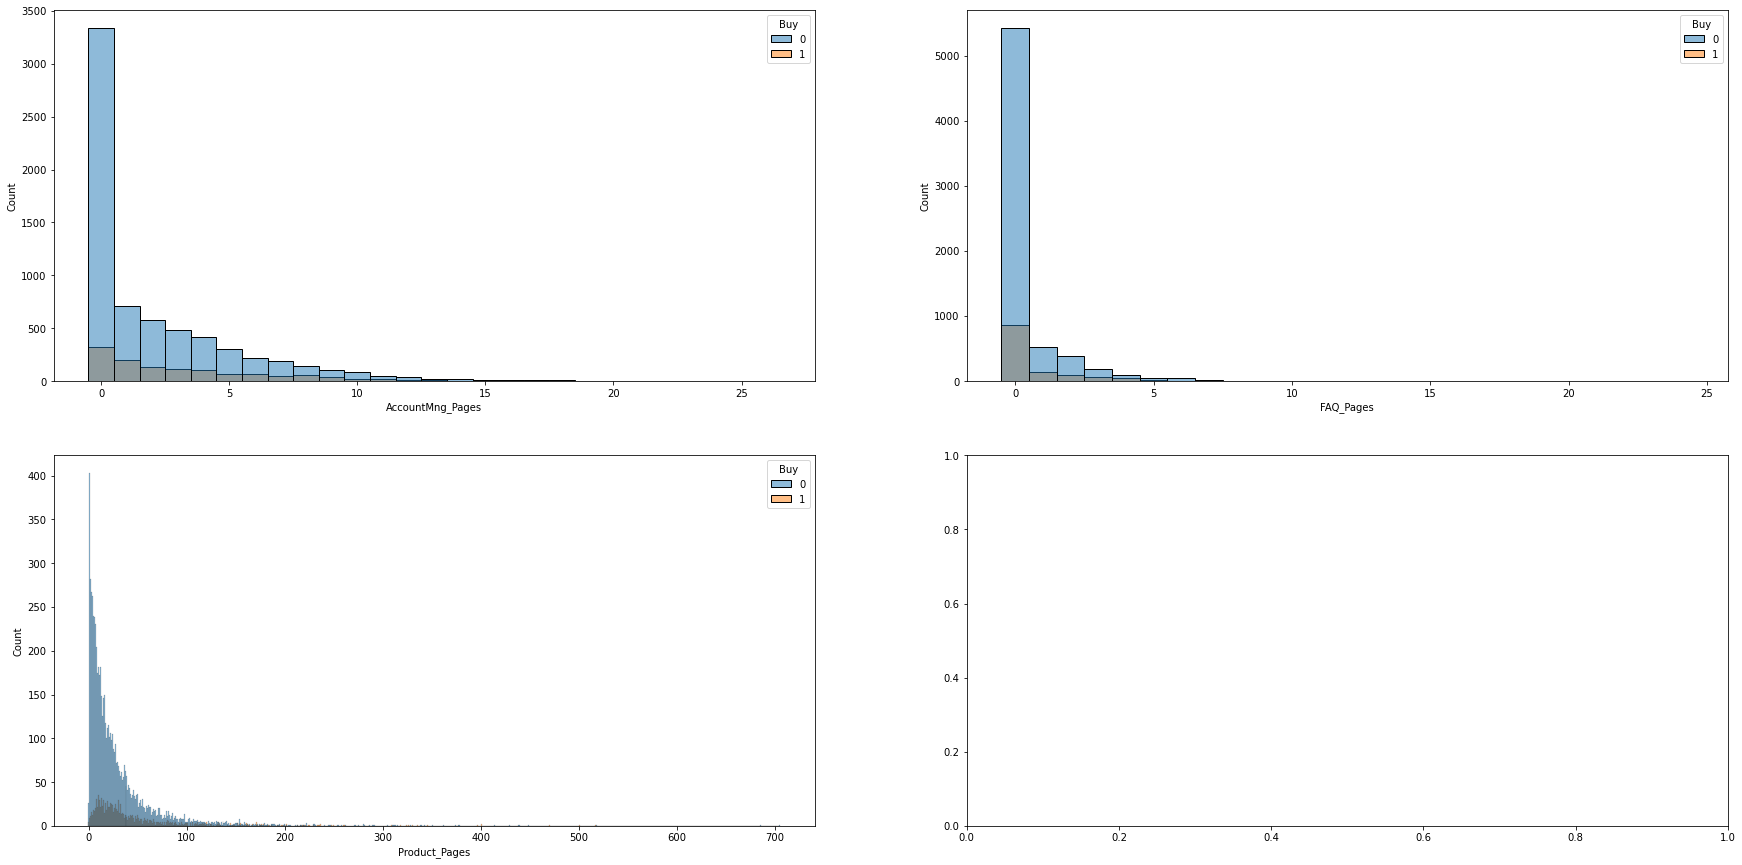

In [20]:
dist_vars =  ['AccountMng_Pages','FAQ_Pages','Product_Pages']
# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(dist_vars) / 2), figsize=(30, 15))
# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), dist_vars): # Notice the zip() function and flatten() method
    sns.histplot(pd.concat([X_train,y_train],axis=1), x=feat, discrete=True, multiple="layer", hue='Buy', ax=ax)
    #ax.set_title(feat, y=-0.15)
plt.show()

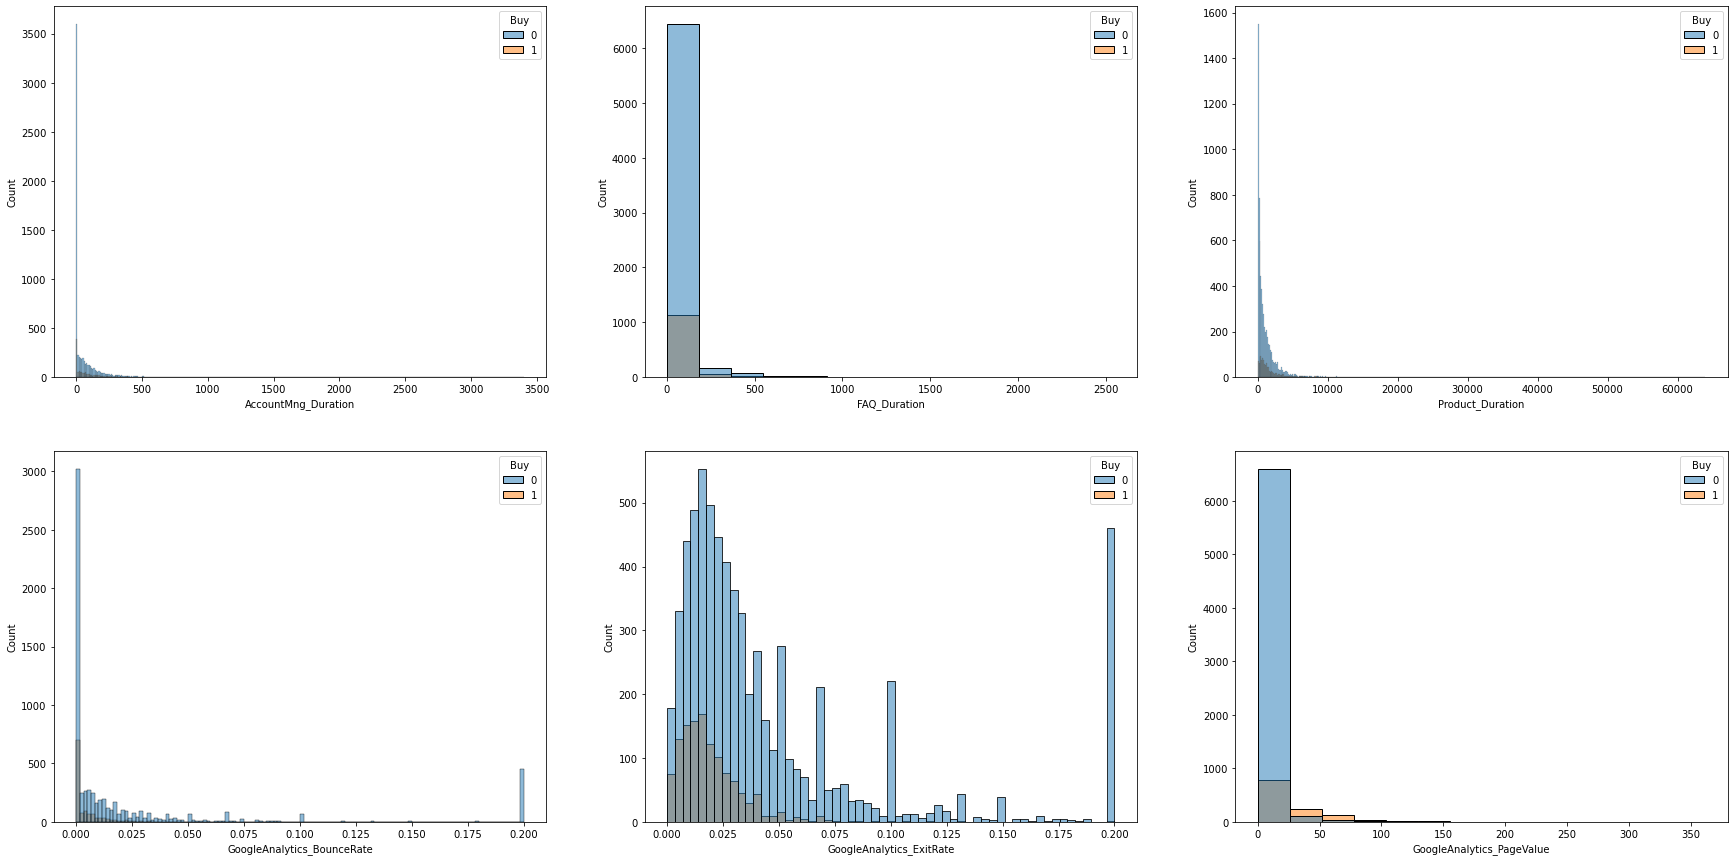

In [23]:
cont_vars =  ['AccountMng_Duration','FAQ_Duration','Product_Duration','GoogleAnalytics_BounceRate','GoogleAnalytics_ExitRate','GoogleAnalytics_PageValue']
# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(cont_vars) / 2), figsize=(30, 15))
# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), cont_vars): # Notice the zip() function and flatten() method
    sns.histplot(pd.concat([X_train,y_train],axis=1), x=feat, multiple="layer", hue='Buy', ax=ax)
    #ax.set_title(feat, y=-0.15)
plt.show()

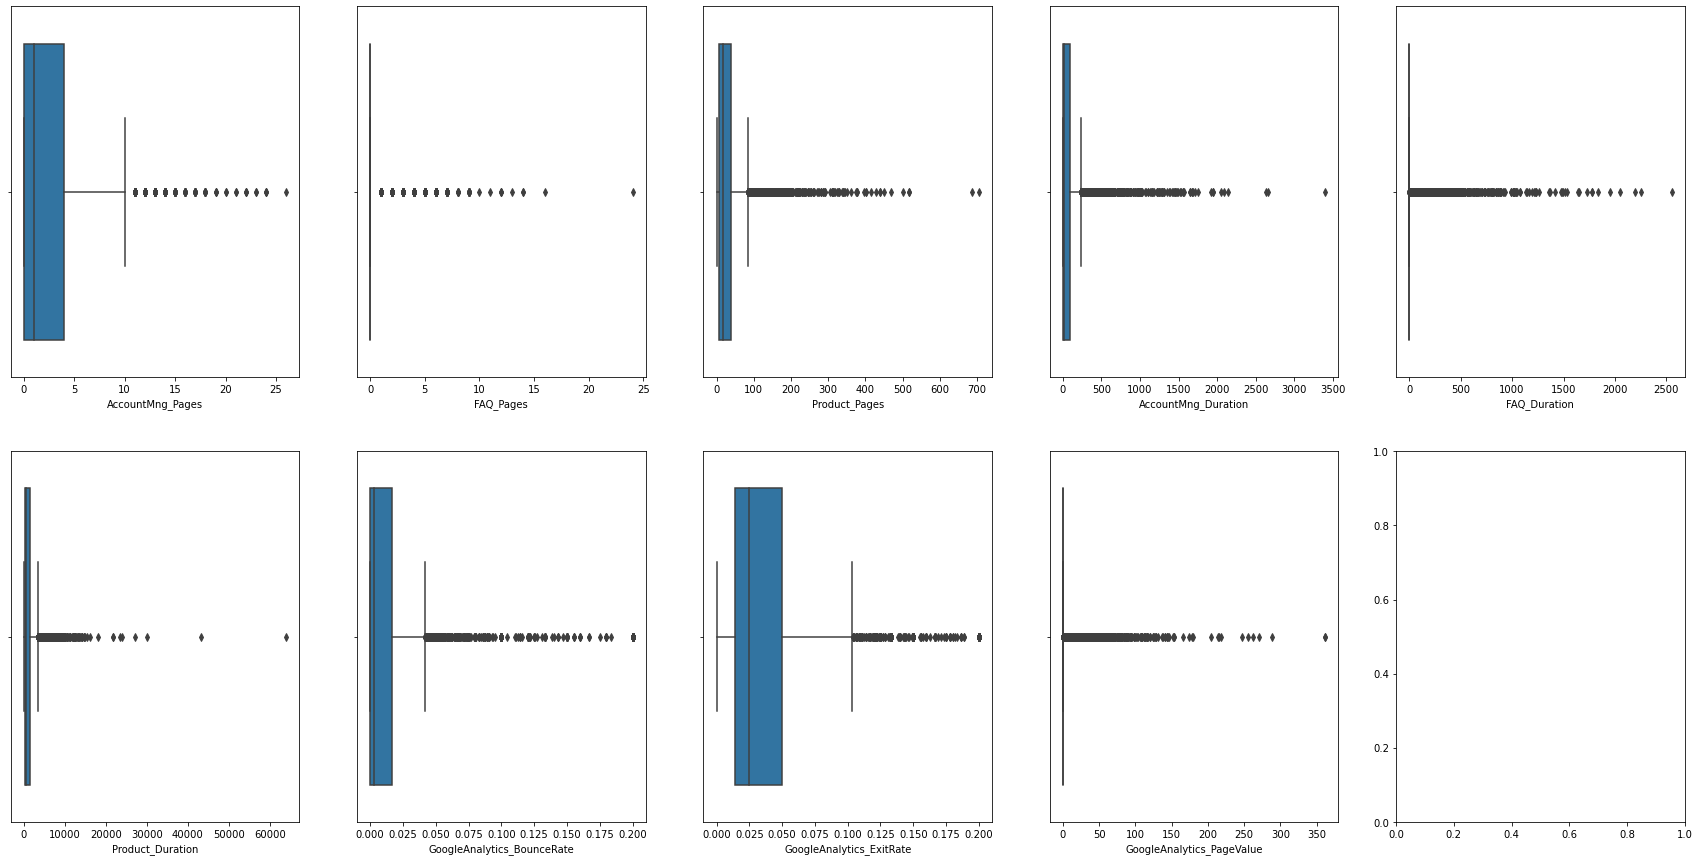

In [24]:
num_vars =  ['AccountMng_Pages','FAQ_Pages','Product_Pages','AccountMng_Duration','FAQ_Duration','Product_Duration','GoogleAnalytics_BounceRate','GoogleAnalytics_ExitRate','GoogleAnalytics_PageValue']
# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(num_vars) / 2), figsize=(30, 15))
# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), num_vars): # Notice the zip() function and flatten() method
    sns.boxplot(data=X_train, x=feat, ax=ax)
    #ax.set_title(feat, y=-0.15)
plt.show()

In [35]:
## function to plot categorical variables distribution and conversion by each of the levels

def plot_feat (df,feat):
    
    dist = pd.Series(df[feat].value_counts(normalize=False), name='Distribution')
    prop = pd.Series(df.groupby(feat).Buy.agg('mean'), name='Conversion')
    dt = pd.concat([dist,prop], axis=1)
    
    fig = plt.figure() # Create matplotlib figure

    ax = fig.add_subplot(111) # Create matplotlib axes
    ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
    dt['Distribution'].plot(kind='bar', color='tab:blue', ax=ax, width=0.4, position=1)
    dt['Conversion'].plot(kind='bar', color='tab:orange', ax=ax2, width=0.4, position=0)

    ax.set_ylabel('# rows')
    ax2.set_ylabel('Conversion (%)')

    plt.show()
    

In [25]:
class_vars = ['OS','Browser','Type_of_Visitor','Type_of_Traffic','Country']

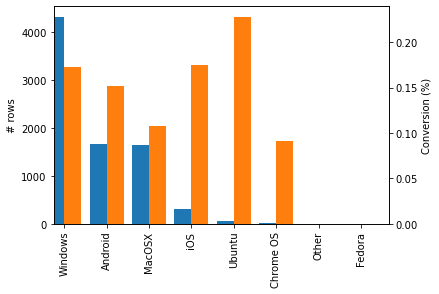

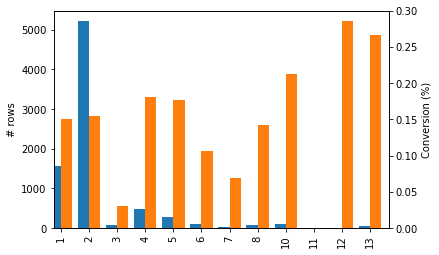

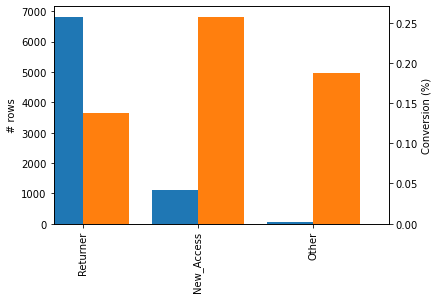

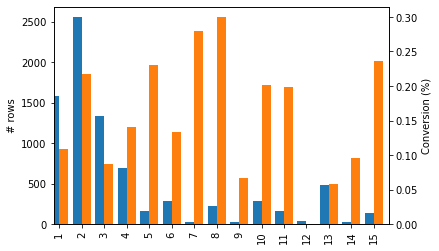

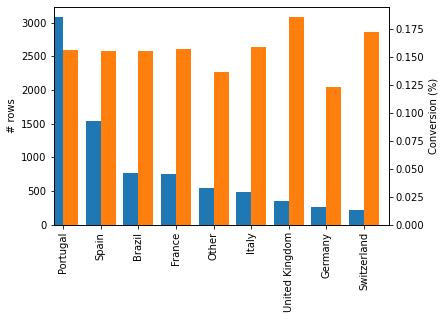

In [36]:
for var in class_vars:
    plot_feat(pd.concat([X_train,y_train],axis=1), var)

In [43]:
def dist_mode(df):
    
    df_out = pd.DataFrame(index=df.columns, columns=['mode','percnt_mode'])
    
    for column in df.columns:
        
        df_out.loc[column, 'mode'] = df[column].mode()[0]
        df_out.loc[column, 'percnt_mode (%)'] = round((len(df.loc[df[column]==df[column].mode()[0]])/len(df))*100,3)
        
    return df_out

In [44]:
df_out = dist_mode(X_train)

In [45]:
df_out

,mode,percnt_mode,percnt_mode (%)
Date,2020-05-25 00:00:00,NaN,1.238
AccountMng_Pages,0,NaN,45.793
AccountMng_Duration,0.0,NaN,47.006
FAQ_Pages,0,NaN,78.560
FAQ_Duration,0.0,NaN,80.398
Product_Pages,1,NaN,5.151
Product_Duration,0.0,NaN,6.201
GoogleAnalytics_BounceRate,0.0,NaN,44.781
GoogleAnalytics_ExitRate,0.2,NaN,5.776
GoogleAnalytics_PageValue,0.0,NaN,77.572


### Pre-processing

In [111]:
X_process = X_train.copy()

In [59]:
X_process.isna().sum()

Date                          0
AccountMng_Pages              0
AccountMng_Duration           0
FAQ_Pages                     0
FAQ_Duration                  0
Product_Pages                 0
Product_Duration              0
GoogleAnalytics_BounceRate    0
GoogleAnalytics_ExitRate      0
GoogleAnalytics_PageValue     0
OS                            0
Browser                       0
Country                       0
Type_of_Traffic               0
Type_of_Visitor               0
dtype: int64

In [48]:
# check if we have duplicates
X_process.duplicated().sum()

9

In [112]:
# remove duplicates
X_process.drop_duplicates(keep='first', inplace=True)

In [62]:
# confirm
X_process.duplicated().sum()

0

In [113]:
X_process = X_process.loc[
    (X_process['AccountMng_Pages']<= 20)
    &
    (X_process['AccountMng_Duration']<=700)
    &
    (X_process['FAQ_Pages']<= 12)
    &
    (X_process['FAQ_Duration']<= 1000)
    &
    (X_process['Product_Pages'] <= 300)
    &
    (X_process['Product_Duration'] <= 12000)
     &
    (X_process['GoogleAnalytics_PageValue'] <= 150)
    &
    (X_process['GoogleAnalytics_ExitRate'] <= 0.2)
    &
    (X_process['GoogleAnalytics_BounceRate'] <= 0.2)
]

In [114]:
print("We kept %0.2f percent of the original data" % (X_process.shape[0]/X_train.shape[0]*100))

We kept 97.06 percent of the original data


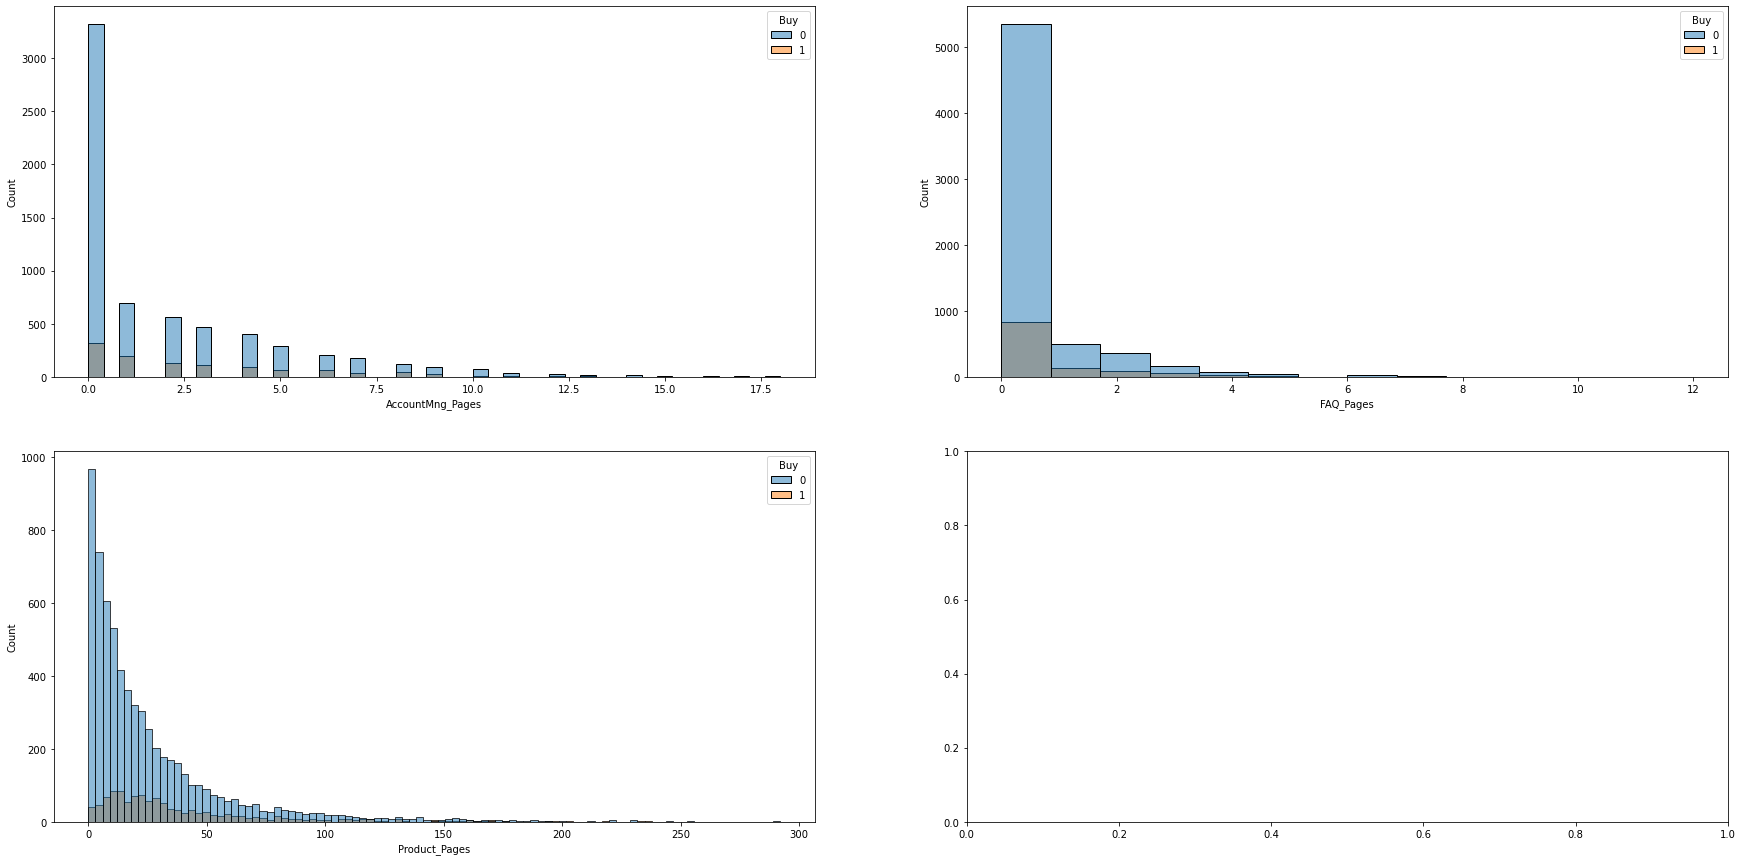

In [66]:
dist_vars =  ['AccountMng_Pages','FAQ_Pages','Product_Pages']
# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(dist_vars) / 2), figsize=(30, 15))
# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), dist_vars): # Notice the zip() function and flatten() method
    sns.histplot(pd.concat([X_process,y_train],axis=1), hue='Buy', x=feat, ax=ax)
    #ax.set_title(feat, y=-0.15)
plt.show()

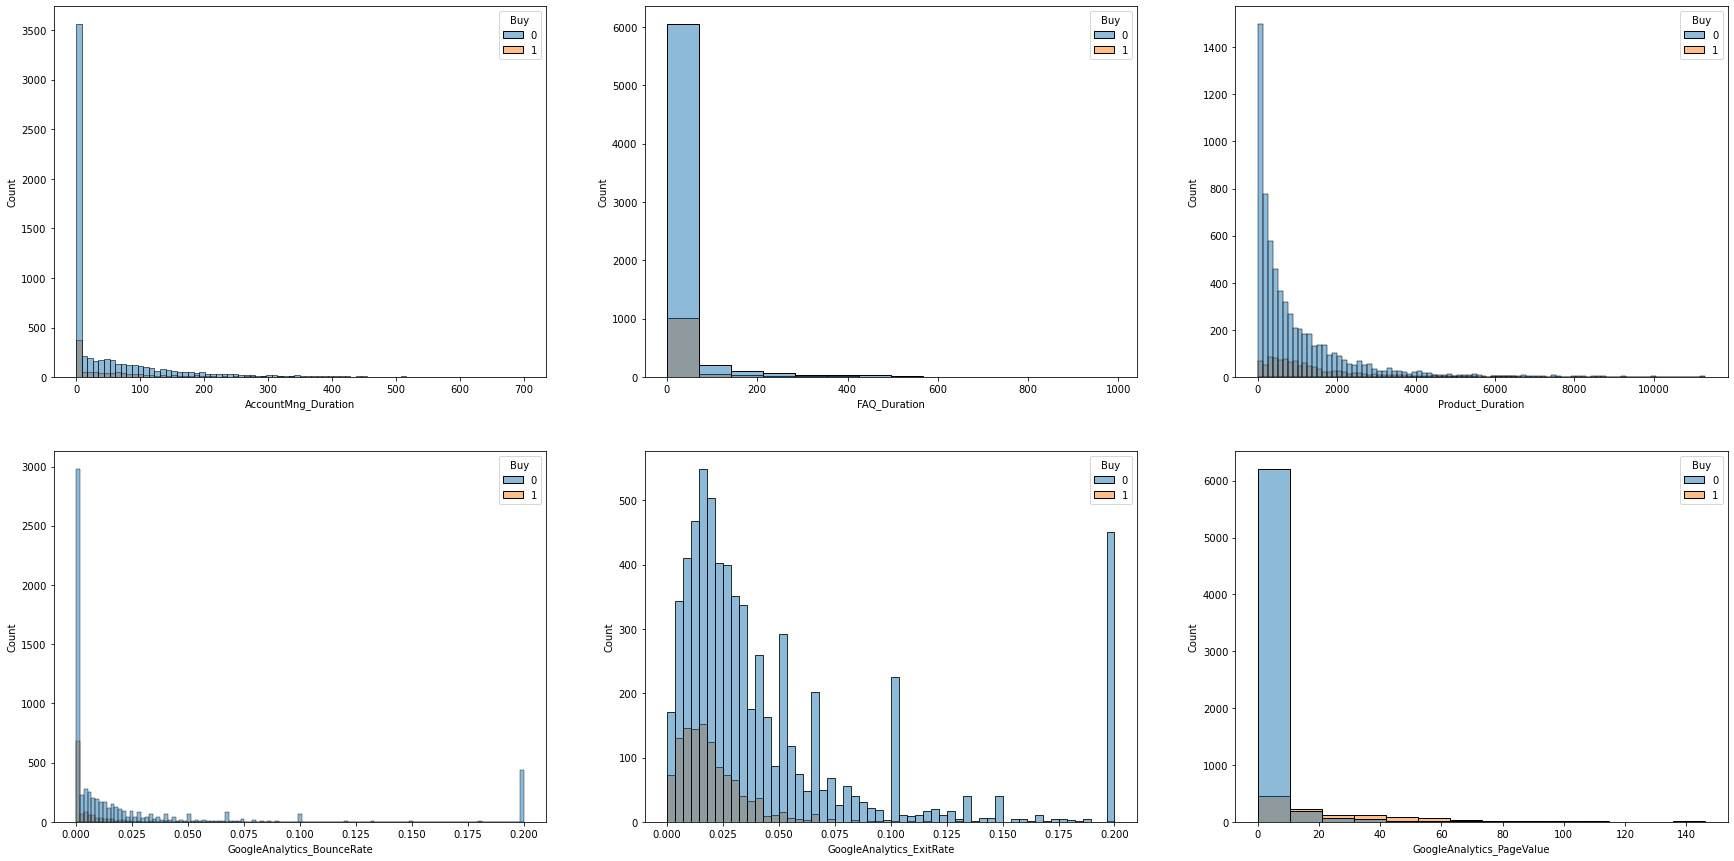

In [67]:
cont_vars =  ['AccountMng_Duration','FAQ_Duration','Product_Duration','GoogleAnalytics_BounceRate','GoogleAnalytics_ExitRate','GoogleAnalytics_PageValue']
# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(cont_vars) / 2), figsize=(30, 15))
# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), cont_vars): # Notice the zip() function and flatten() method
    sns.histplot(pd.concat([X_process,y_train],axis=1), hue='Buy', x=feat, ax=ax)
    #ax.set_title(feat, y=-0.15)
plt.show()

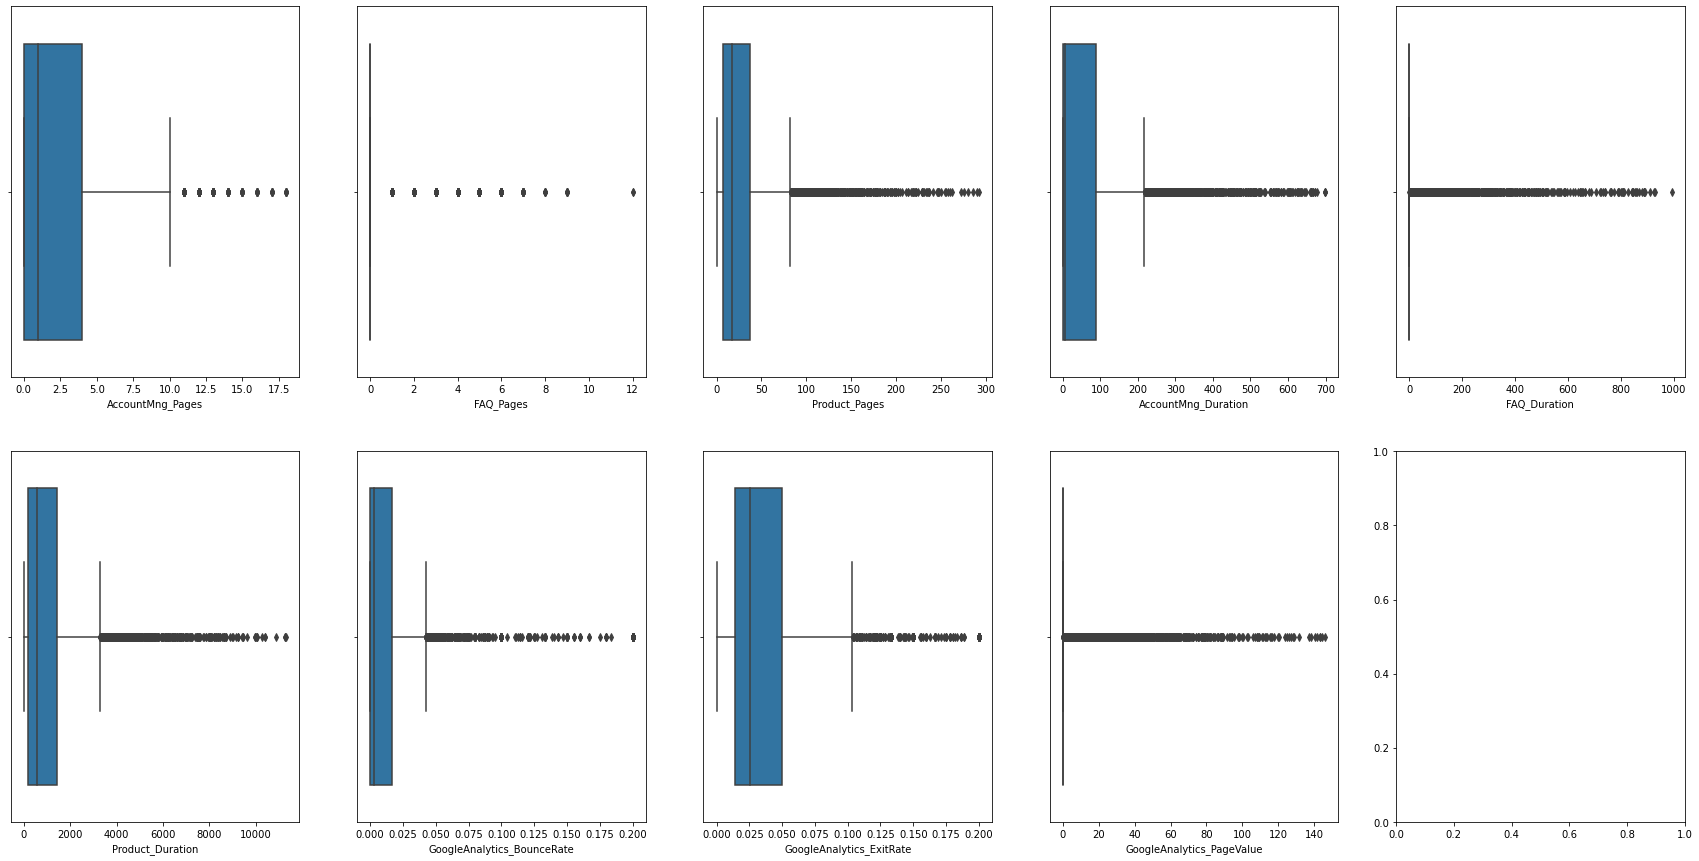

In [68]:
num_vars =  ['AccountMng_Pages','FAQ_Pages','Product_Pages','AccountMng_Duration','FAQ_Duration','Product_Duration','GoogleAnalytics_BounceRate','GoogleAnalytics_ExitRate','GoogleAnalytics_PageValue']
# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(num_vars) / 2), figsize=(30, 15))
# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), num_vars): # Notice the zip() function and flatten() method
    sns.boxplot(data=X_process, x=feat, ax=ax)
    #ax.set_title(feat, y=-0.15)
plt.show()

In [115]:
# filter y to have the some observasions
y_train = y_train[X_process.index]

In [70]:
print(len(X_process))
print(len(y_train))

7764
7764


#### Build new variables

In [116]:
# get details from the date
X_process['Month_Access'] = X_process.Date.apply(lambda x: x.month)
X_process['WDay_Access'] = X_process.Date.apply(lambda x: x.weekday()) ## monday is 0
#X_process['Day_Access'] = X_process.Date.apply(lambda x: x.day)

# calculate new variables

# # total number of pages visited and total durantion of visits
X_process['Total_Pages'] = X_process['AccountMng_Pages']+X_process['FAQ_Pages']+X_process['Product_Pages']
X_process['Total_Duration'] = X_process['AccountMng_Duration']+X_process['FAQ_Duration']+X_process['Product_Duration']

# # proportion of visits by each pages and duration
X_process['Prop_AccountMng_Pages'] = X_process['AccountMng_Pages']/X_process['Total_Pages']
X_process['Prop_FAQ_Pages'] = X_process['FAQ_Pages']/X_process['Total_Pages']
X_process['Prop_Product_Pages'] = X_process['Product_Pages']/X_process['Total_Pages']

X_process['Prop_AccountMng_Duration'] = X_process['AccountMng_Duration']/X_process['Total_Duration']
X_process['Prop_FAQ_Duration'] = X_process['FAQ_Duration']/X_process['Total_Duration']
X_process['Prop_Product_Duration'] = X_process['Product_Duration']/X_process['Total_Duration']

# # averages times spent in each page
X_process['Avg_AccountMng_Duration'] = X_process['AccountMng_Duration']/X_process['AccountMng_Pages']
X_process['Avg_FAQ_Duration'] = X_process['FAQ_Duration']/X_process['FAQ_Pages']
X_process['Avg_Product_Duration'] = X_process['Product_Duration']/X_process['Product_Pages']

# # total average
X_process['Avg_Duration'] = X_process['Total_Duration']/X_process['Total_Pages']

In [117]:
X_process.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7764 entries, 579558156 to 210337741
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Date                        7764 non-null   datetime64[ns]
 1   AccountMng_Pages            7764 non-null   int64         
 2   AccountMng_Duration         7764 non-null   float64       
 3   FAQ_Pages                   7764 non-null   int64         
 4   FAQ_Duration                7764 non-null   float64       
 5   Product_Pages               7764 non-null   int64         
 6   Product_Duration            7764 non-null   float64       
 7   GoogleAnalytics_BounceRate  7764 non-null   float64       
 8   GoogleAnalytics_ExitRate    7764 non-null   float64       
 9   GoogleAnalytics_PageValue   7764 non-null   float64       
 10  OS                          7764 non-null   object        
 11  Browser                     7764 non-null  

In [118]:
X_process.isna().sum()

Date                             0
AccountMng_Pages                 0
AccountMng_Duration              0
FAQ_Pages                        0
FAQ_Duration                     0
Product_Pages                    0
Product_Duration                 0
GoogleAnalytics_BounceRate       0
GoogleAnalytics_ExitRate         0
GoogleAnalytics_PageValue        0
OS                               0
Browser                          0
Country                          0
Type_of_Traffic                  0
Type_of_Visitor                  0
Month_Access                     0
WDay_Access                      0
Total_Pages                      0
Total_Duration                   0
Prop_AccountMng_Pages            6
Prop_FAQ_Pages                   6
Prop_Product_Pages               6
Prop_AccountMng_Duration       459
Prop_FAQ_Duration              459
Prop_Product_Duration          459
Avg_AccountMng_Duration       3637
Avg_FAQ_Duration              6187
Avg_Product_Duration            31
Avg_Duration        

In [119]:
# got some nans because of the division by 0
X_process.fillna(0, inplace=True)

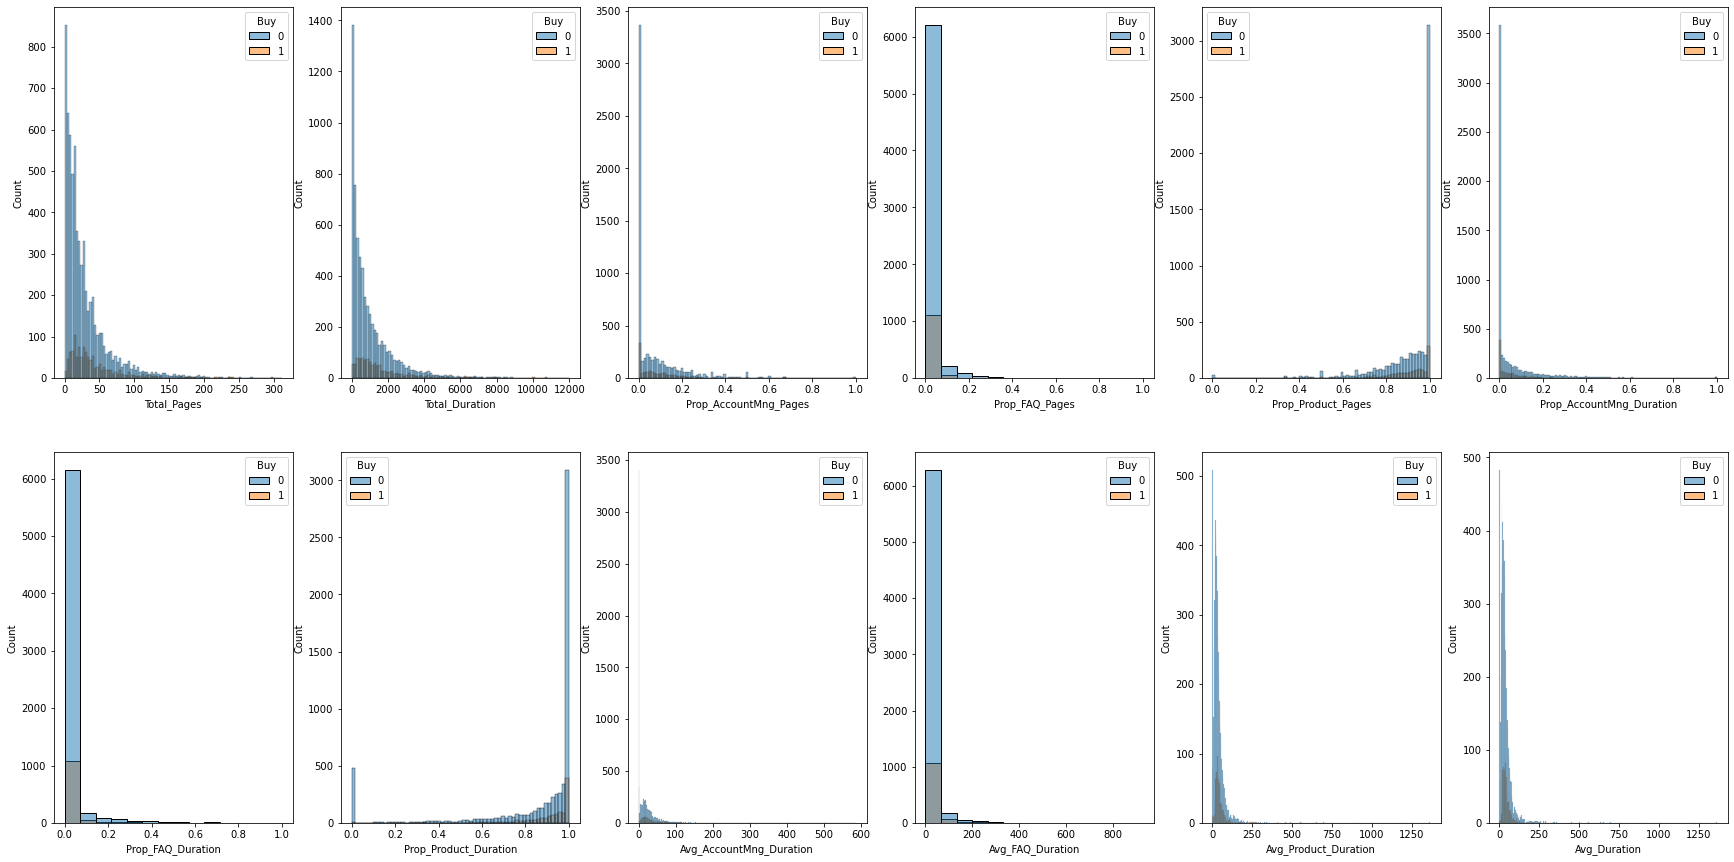

In [76]:
new_num_vars = ['Total_Pages','Total_Duration','Prop_AccountMng_Pages','Prop_FAQ_Pages','Prop_Product_Pages','Prop_AccountMng_Duration',
                'Prop_FAQ_Duration','Prop_Product_Duration','Avg_AccountMng_Duration','Avg_FAQ_Duration','Avg_Product_Duration','Avg_Duration']

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(new_num_vars) / 2), figsize=(30, 15))
# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), new_num_vars): # Notice the zip() function and flatten() method
    sns.histplot(pd.concat([X_process,y_train],axis=1), hue='Buy', x=feat, ax=ax)
    #ax.set_title(feat, y=-0.15)
plt.show()

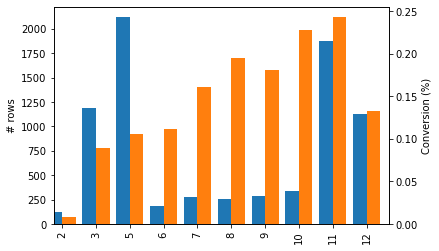

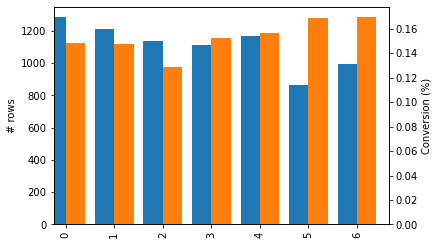

In [79]:
date_vars = ['Month_Access','WDay_Access']
for var in date_vars:
    plot_feat(pd.concat([X_process,y_train],axis=1), var)

In [80]:
X_corr_pears = pd.concat([X_process,y_train], axis=1).corr()
X_corr_pears

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Browser,...,Prop_FAQ_Pages,Prop_Product_Pages,Prop_AccountMng_Duration,Prop_FAQ_Duration,Prop_Product_Duration,Avg_AccountMng_Duration,Avg_FAQ_Duration,Avg_Product_Duration,Avg_Duration,Buy
AccountMng_Pages,1.000000,0.717686,0.344349,0.247234,0.405328,0.355171,-0.228912,-0.324276,0.113114,-0.021927,...,0.090854,-0.497114,0.393485,0.116903,-0.093861,0.250948,0.181363,-0.008068,-0.020382,0.129105
AccountMng_Duration,0.717686,1.000000,0.295324,0.203689,0.287822,0.283183,-0.187666,-0.269849,0.099770,-0.025825,...,0.096303,-0.400496,0.507398,0.082002,-0.171896,0.676227,0.139517,0.038592,0.067244,0.117543
FAQ_Pages,0.344349,0.295324,1.000000,0.658529,0.350493,0.342053,-0.115491,-0.164628,0.062148,-0.038640,...,0.566599,-0.241416,0.020751,0.512236,-0.060667,0.136730,0.366175,0.020003,0.024717,0.083072
FAQ_Duration,0.247234,0.203689,0.658529,1.000000,0.255552,0.268304,-0.082884,-0.121834,0.045832,-0.008117,...,0.344647,-0.148607,-0.012816,0.631516,-0.099541,0.097379,0.821422,0.039696,0.072227,0.076159
Product_Pages,0.405328,0.287822,0.350493,0.255552,1.000000,0.850401,-0.231085,-0.331892,0.079022,-0.013409,...,-0.021548,0.129824,-0.131503,0.007114,0.243959,0.115826,0.188445,-0.009090,-0.010781,0.156461
Product_Duration,0.355171,0.283183,0.342053,0.268304,0.850401,1.000000,-0.219374,-0.301710,0.081442,-0.007237,...,-0.004926,0.112492,-0.164082,-0.006593,0.260152,0.131311,0.208002,0.249837,0.241786,0.164078
GoogleAnalytics_BounceRate,-0.228912,-0.187666,-0.115491,-0.082884,-0.231085,-0.219374,1.000000,0.910264,-0.129017,-0.008073,...,-0.045845,0.144239,-0.156085,-0.063598,-0.677047,-0.161096,-0.072421,-0.185427,-0.190145,-0.146362
GoogleAnalytics_ExitRate,-0.324276,-0.269849,-0.164628,-0.121834,-0.331892,-0.301710,0.910264,1.000000,-0.187360,0.003266,...,-0.050067,0.172029,-0.173501,-0.074431,-0.587802,-0.218332,-0.105736,-0.151631,-0.153913,-0.203950
GoogleAnalytics_PageValue,0.113114,0.099770,0.062148,0.045832,0.079022,0.081442,-0.129017,-0.187360,1.000000,0.042012,...,-0.006231,-0.008685,-0.011789,0.003107,0.082470,0.081933,0.033554,0.044849,0.041418,0.538298
Browser,-0.021927,-0.025825,-0.038640,-0.008117,-0.013409,-0.007237,-0.008073,0.003266,0.042012,1.000000,...,-0.030282,0.013352,-0.002531,-0.020900,0.000263,-0.019884,0.001736,0.000812,-0.000877,0.022172


In [81]:
X_corr_spear = pd.concat([X_process,y_train], axis=1).corr(method='spearman')
X_corr_spear

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Browser,...,Prop_FAQ_Pages,Prop_Product_Pages,Prop_AccountMng_Duration,Prop_FAQ_Duration,Prop_Product_Duration,Avg_AccountMng_Duration,Avg_FAQ_Duration,Avg_Product_Duration,Avg_Duration,Buy
AccountMng_Pages,1.000000,0.939315,0.356976,0.349792,0.450379,0.401544,-0.160777,-0.436149,0.315352,-0.018705,...,0.337664,-0.859150,0.881472,0.340672,-0.621112,0.831032,0.347331,0.148490,0.156034,0.160299
AccountMng_Duration,0.939315,1.000000,0.344173,0.337463,0.419178,0.391100,-0.170524,-0.441124,0.305347,-0.027692,...,0.327815,-0.828554,0.930194,0.328037,-0.661645,0.951390,0.335065,0.181590,0.224117,0.158473
FAQ_Pages,0.356976,0.344173,1.000000,0.947914,0.355073,0.342741,0.004759,-0.186199,0.196772,-0.030462,...,0.991277,-0.406465,0.234258,0.945807,-0.312938,0.291997,0.941952,0.145165,0.162720,0.097173
FAQ_Duration,0.349792,0.337463,0.947914,1.000000,0.343562,0.333374,-0.004109,-0.199239,0.192887,-0.023432,...,0.934565,-0.385229,0.227417,0.996422,-0.326723,0.287079,0.998409,0.144506,0.172321,0.091017
Product_Pages,0.450379,0.419178,0.355073,0.343562,1.000000,0.880774,-0.046268,-0.519812,0.335572,0.038736,...,0.311309,-0.185305,0.228835,0.319434,0.040414,0.365501,0.341839,0.306163,0.283024,0.189126
Product_Duration,0.401544,0.391100,0.342741,0.333374,0.880774,1.000000,-0.072044,-0.474060,0.351062,0.041744,...,0.303987,-0.175985,0.171365,0.305737,0.102453,0.352168,0.331628,0.676519,0.649414,0.206488
GoogleAnalytics_BounceRate,-0.160777,-0.170524,0.004759,-0.004109,-0.046268,-0.072044,1.000000,0.593087,-0.122637,-0.042641,...,-0.001721,0.195935,-0.216393,-0.008304,-0.077535,-0.182868,-0.006137,-0.173689,-0.178652,-0.141466
GoogleAnalytics_ExitRate,-0.436149,-0.441124,-0.186199,-0.199239,-0.519812,-0.474060,0.593087,1.000000,-0.303597,-0.014486,...,-0.175671,0.353818,-0.398225,-0.193531,0.098511,-0.427743,-0.200530,-0.263276,-0.260205,-0.248800
GoogleAnalytics_PageValue,0.315352,0.305347,0.196772,0.192887,0.335572,0.351062,-0.122637,-0.303597,1.000000,0.014302,...,0.179131,-0.205207,0.208407,0.181380,-0.104967,0.277017,0.191548,0.211566,0.200372,0.631158
Browser,-0.018705,-0.027692,-0.030462,-0.023432,0.038736,0.041744,-0.042641,-0.014486,0.014302,1.000000,...,-0.032524,0.041073,-0.034269,-0.025070,0.052219,-0.031130,-0.021417,0.031138,0.027048,0.012480


In [137]:
X_corr_pears.to_excel('..\correlation_pears.xlsx')
X_corr_spear.to_excel('..\correlation_spear.xlsx')

In [120]:
X_process[class_vars]

,OS,Browser,Type_of_Visitor,Type_of_Traffic,Country
Access_ID,,,,,
579558156,Windows,2,Returner,3,Italy
317781105,Windows,2,Returner,3,Portugal
607317379,Android,1,Returner,3,Portugal
474356679,Windows,5,New_Access,8,Spain
487584836,Windows,2,Returner,1,Italy
...,...,...,...,...,...
687152530,Windows,2,Returner,5,Spain
142503914,MacOSX,2,New_Access,2,Other
250931766,Android,1,Returner,2,Portugal


In [121]:
## encoding categorical data
# enc = OneHotEncoder(sparse=False)
# categoric_feat = enc.fit_transform(X_process[class_vars])
# categoric_names = enc.get_feature_names()
# df_categoric = pd.DataFrame(categoric_feat, index=X_process.index, columns=categoric_names)
# df_numerics = X_process.drop(columns=['OS', 'Browser', 'Type_of_Visitor', 'Type_of_Traffic', 'Country'])

In [37]:
# create dummy varibles for value in mode for varibles with mode % > 70%

# X_process['dum_FAQ_Pages'] = np.where(X_process['FAQ_Pages']==0,1,0)
# X_process['dum_FAQ_Duration'] = np.where(X_process['FAQ_Duration']==0,1,0)
# X_process['dum_GoogleAnalytics_PageValue'] = np.where(X_process['GoogleAnalytics_PageValue']==0,1,0)

# # creating dummys for the levels
# X_process['Visitor_Returner'] = np.where(X_process['Type_of_Visitor']=='Returner',1,0)
# X_process['OS_Windows'] = np.where(X_process['OS']=='Windows',1,0)
# X_process['OS_Android'] = np.where(X_process['OS']=='Android',1,0)
# X_process['OS_MacOSX'] = np.where(X_process['OS']=='MacOSX',1,0)
# X_process['Browser_1'] = np.where(X_process['Browser']==1,1,0)
# X_process['Browser_2'] = np.where(X_process['Browser']==2,1,0)
# X_process['Browser_4'] = np.where(X_process['Browser']==4,1,0)

# binning discrete variables with large number of observations in the mode

# X_process['Q_Product_Pages'] = pd.qcut(X_process.Product_Pages, 4, duplicates='drop')
# X_process['Q_Product_Duration'] = pd.qcut(X_process.Product_Duration, 4, duplicates='drop')
# X_process['Q_AccountMng_Pages'] = pd.qcut(X_process.AccountMng_Pages, 4, duplicates='drop')
# X_process['Q_AccountMng_Duration'] = pd.qcut(X_process.AccountMng_Duration, 4, duplicates='drop')
# X_process['Q_GoogleAnalytics_ExitRate'] = pd.qcut(X_process.GoogleAnalytics_ExitRate, 4, duplicates='drop')
# X_process['Q_GoogleAnalytics_BounceRate'] = pd.qcut(X_process.GoogleAnalytics_BounceRate, 4, duplicates='drop')

In [122]:
## encoding

dummy_os = pd.get_dummies(X_process['OS'], prefix='OS')
dummy_browser = pd.get_dummies(X_process['Browser'], prefix='Browser')
dummy_country = pd.get_dummies(X_process['Country'], prefix='Country')
dummy_traffic = pd.get_dummies(X_process['Type_of_Traffic'], prefix='Traffic')
dummy_visitor = pd.get_dummies(X_process['Type_of_Visitor'], prefix='Visitor')
# dummy_wday = pd.get_dummies(df_process['WDay_Access'], prefix='Wday')

X_process = pd.concat([X_process, dummy_os, dummy_browser, dummy_country, dummy_traffic, dummy_visitor], axis=1)

In [123]:
X_process.drop(['Date','OS','Browser','Country','Type_of_Traffic','Type_of_Visitor'], axis=1, inplace=True)

In [124]:
print(X_process.shape)

(7764, 70)


In [125]:
print(y_train.shape)

(7764,)


In [127]:
# prepares test data

# get details from the date
X_test['Month_Access'] = X_test.Date.apply(lambda x: x.month)
X_test['WDay_Access'] = X_test.Date.apply(lambda x: x.weekday()) ## monday is 0

#X_test['Day_Access'] = X_test.Date.apply(lambda x: x.day)

# calculate new variables

# total number of pages visited and total durantion of visits
X_test['Total_Pages'] = X_test['AccountMng_Pages']+X_test['FAQ_Pages']+X_test['Product_Pages']
X_test['Total_Duration'] = X_test['AccountMng_Duration']+X_test['FAQ_Duration']+X_test['Product_Duration']

# # proportion of visits by each pages and duration
X_test['Prop_AccountMng_Pages'] = X_test['AccountMng_Pages']/X_test['Total_Pages']
X_test['Prop_FAQ_Pages'] = X_test['FAQ_Pages']/X_test['Total_Pages']
X_test['Prop_Product_Pages'] = X_test['Product_Pages']/X_test['Total_Pages']

X_test['Prop_AccountMng_Duration'] = X_test['AccountMng_Duration']/X_test['Total_Duration']
X_test['Prop_FAQ_Duration'] = X_test['FAQ_Duration']/X_test['Total_Duration']
X_test['Prop_Product_Duration'] = X_test['Product_Duration']/X_test['Total_Duration']

# # averages times spent in each page
X_test['Avg_AccountMng_Duration'] = X_test['AccountMng_Duration']/X_test['AccountMng_Pages']
X_test['Avg_FAQ_Duration'] = X_test['FAQ_Duration']/X_test['FAQ_Pages']
X_test['Avg_Product_Duration'] = X_test['Product_Duration']/X_test['Product_Pages']

# total average
X_test['Avg_Duration'] = X_test['Total_Duration']/X_test['Total_Pages']

# got some nans because of the division by 0
X_test.fillna(0, inplace=True)

# create dummy varibles for value in mode for varibles with mode % > 70%

# X_test['dum_FAQ_Pages'] = np.where(X_test['FAQ_Pages']==0,1,0)
# X_test['dum_FAQ_Duration'] = np.where(X_test['FAQ_Duration']==0,1,0)
# X_test['dum_GoogleAnalytics_PageValue'] = np.where(X_test['GoogleAnalytics_PageValue']==0,1,0)

# creating dummys for the levels
# X_test['Visitor_Returner'] = np.where(X_test['Type_of_Visitor']=='Returner',1,0)
# X_test['OS_Windows'] = np.where(X_test['OS']=='Windows',1,0)
# X_test['OS_Android'] = np.where(X_test['OS']=='Android',1,0)
# X_test['OS_MacOSX'] = np.where(X_test['OS']=='MacOSX',1,0)
# X_test['Browser_1'] = np.where(X_test['Browser']==1,1,0)
# X_test['Browser_2'] = np.where(X_test['Browser']==2,1,0)
# X_test['Browser_4'] = np.where(X_test['Browser']==4,1,0)

## encoding
dummy_os = pd.get_dummies(X_test['OS'], prefix='OS')
dummy_browser = pd.get_dummies(X_test['Browser'], prefix='Browser')
dummy_country = pd.get_dummies(X_test['Country'], prefix='Country')
dummy_traffic = pd.get_dummies(X_test['Type_of_Traffic'], prefix='Traffic')
dummy_visitor = pd.get_dummies(X_test['Type_of_Visitor'], prefix='Visitor')

X_test = pd.concat([X_test, dummy_os, dummy_browser, dummy_country, dummy_traffic, dummy_visitor], axis=1)

X_test.drop(['Date','OS','Browser','Country','Type_of_Traffic','Type_of_Visitor'], axis=1, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:5171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


## Models

### Tree Based Models

In [ ]:
# Decision Tree

In [128]:
Decisiontree = DecisionTreeClassifier(random_state=54).fit(X_process,y_train)

In [129]:
train_score = []
test_score = []

depths = [2,3,4,5,6,7,8]
for depth in depths:
    Decisiontree = Decisiontree.set_params(max_depth=depth).fit(X_process,y_train)
    train_score.append(metrics.f1_score(y_train,np.where(Decisiontree.predict_proba(X_process)[:,1]>=0.155,1,0)))
    test_score.append(metrics.f1_score(y_test,np.where(Decisiontree.predict_proba(X_test)[:,1]>=0.155,1,0)))
    

In [130]:
test_score

[0.6639676113360324,
 0.624413145539906,
 0.6294536817102139,
 0.6431181485992692,
 0.6402877697841727,
 0.6340852130325815,
 0.6472222222222221]

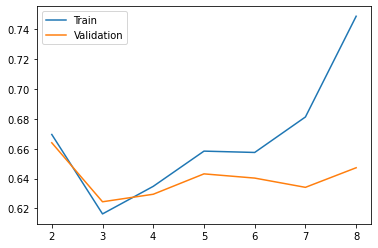

In [131]:
plt.plot(depths, train_score, label='Train')
plt.plot(depths, test_score, label = 'Validation')
plt.xticks(depths)
plt.legend()
plt.show()

In [76]:
#dt_parameters = {'max_depth':(3,4,5,6,7,8)}

In [77]:
#dt_Grid = GridSearchCV(Decisiontree, dt_parameters, scoring='f1', cv=4).fit(X_process,y_train)

In [211]:
#dt_Grid.cv_results_

In [212]:
#dt_Grid.best_estimator_

In [132]:
Decisiontree.set_params(max_depth=2).fit(X_process, y_train)

DecisionTreeClassifier(max_depth=2, random_state=54)

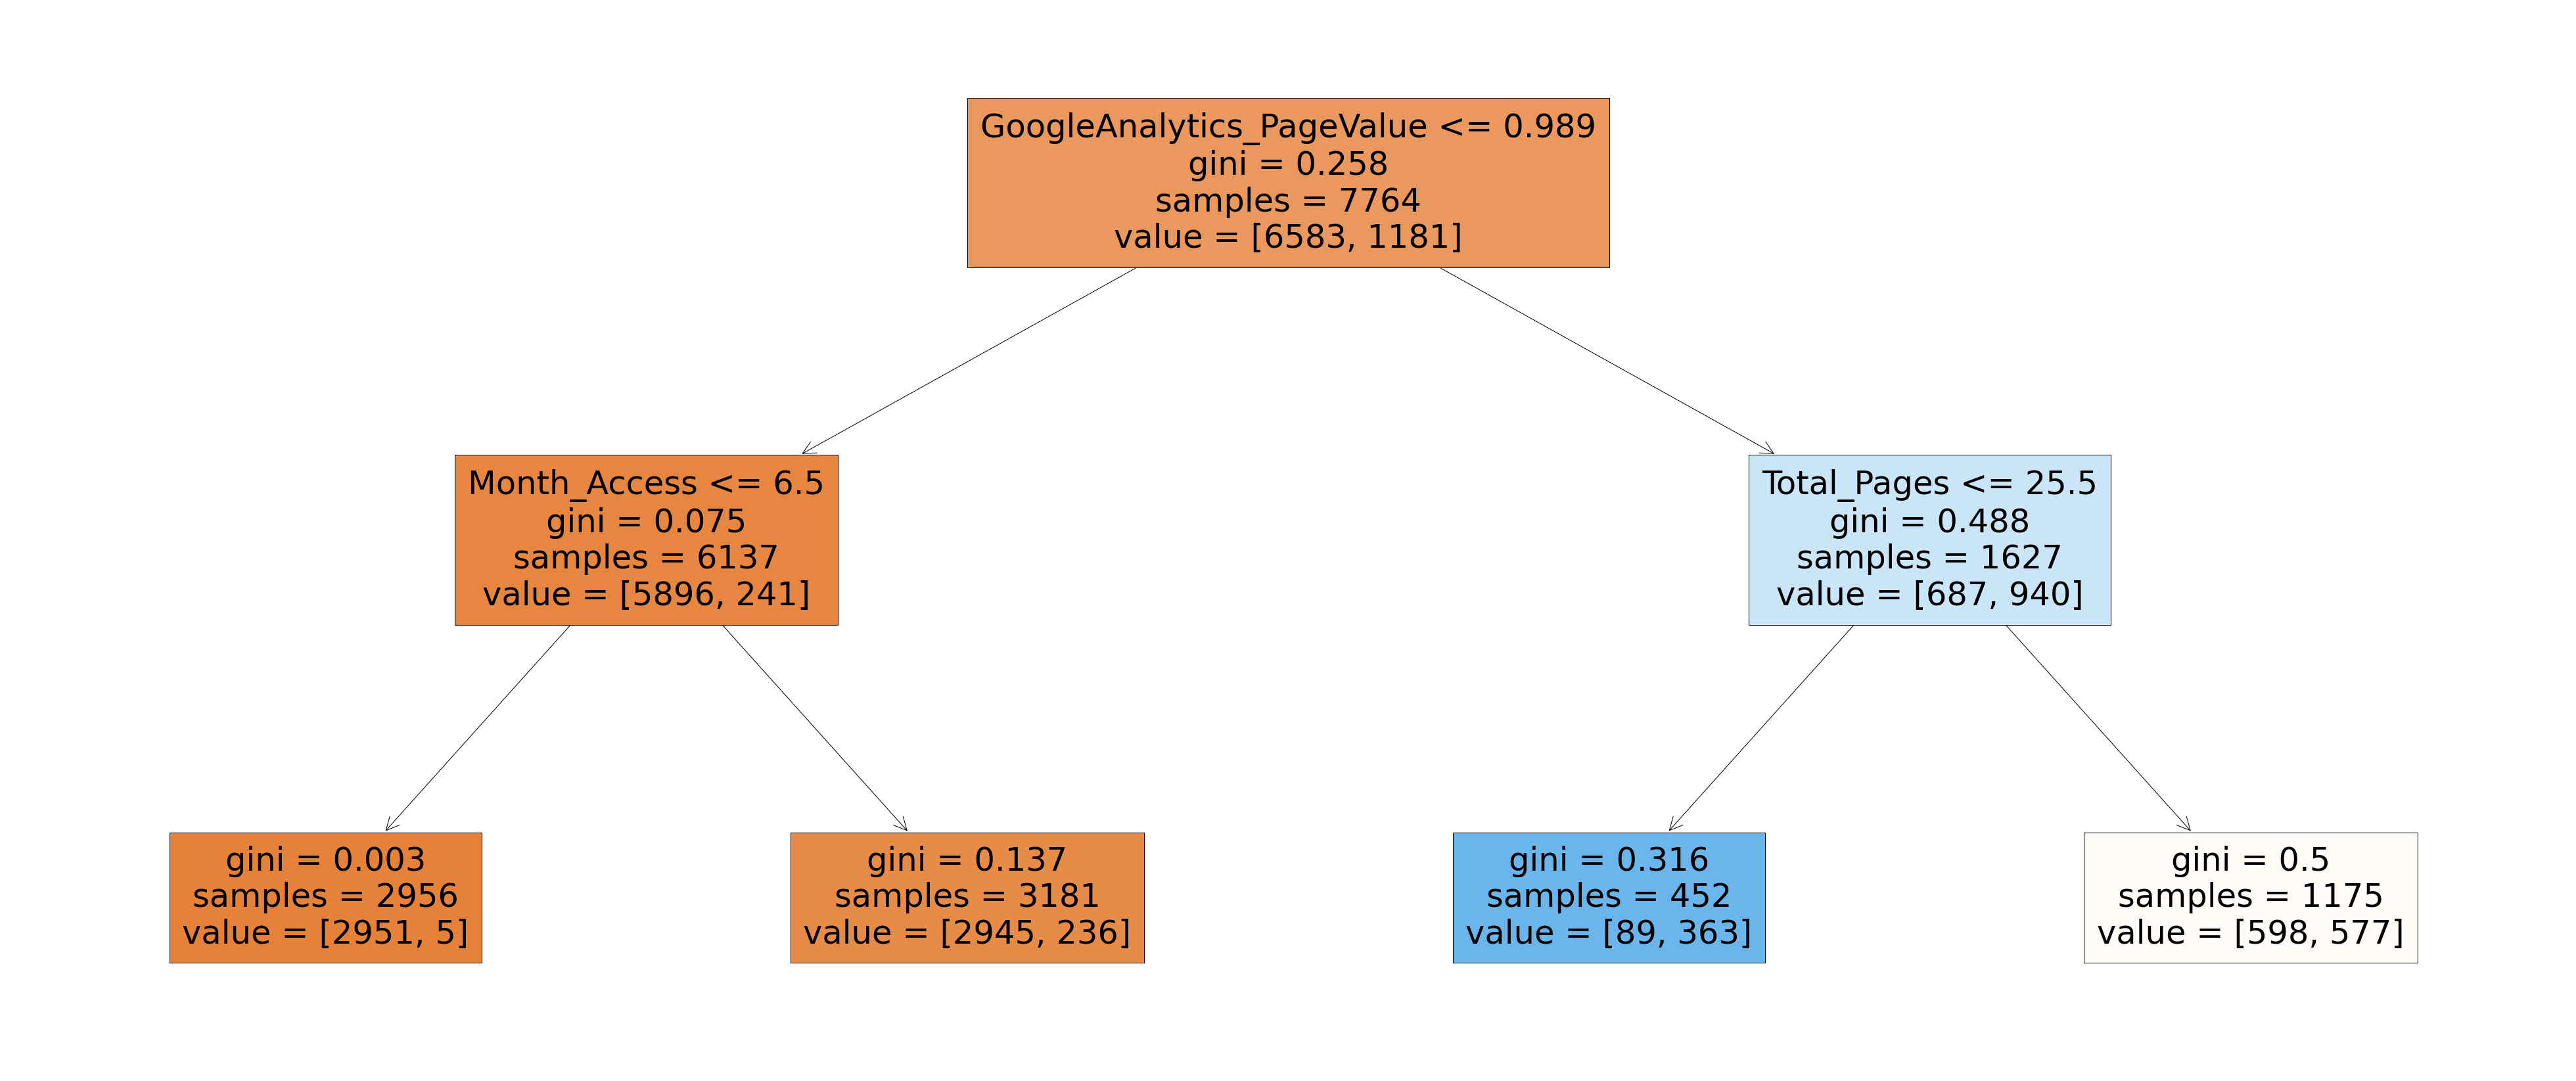

In [133]:
fig = plt.figure(figsize=(70,30))
tree.plot_tree(Decisiontree, feature_names=X_process.columns, filled=True)
plt.show()

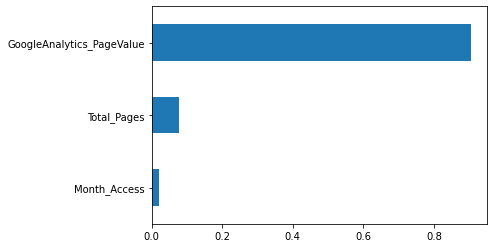

In [134]:
dt_featimp = pd.Series(Decisiontree.feature_importances_, index=X_process.columns)
dt_featimp = dt_featimp[dt_featimp>=0.001]
dt_featimp.sort_values().plot(kind='barh')
plt.show()

In [212]:
DT_train_class = np.where(Decisiontree.predict_proba(X_process)[:,1]>=0.375,1,0)
DT_test_class = np.where(Decisiontree.predict_proba(X_test)[:,1]>=0.375,1,0)

In [213]:
print('------ Train metrics' + '\n')
print('Precision: '+ str(round(metrics.precision_score(y_train, DT_train_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_train, DT_train_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_train, DT_train_class),3)))

print('\n')
print('------ Validation metrics' + '\n')

print('Precision: '+ str(round(metrics.precision_score(y_test, DT_test_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_test, DT_test_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_test, DT_test_class),3)))


------ Train metrics

Precision: 0.578
Recall: 0.796
F1 Score: 0.67


------ Validation metrics

Precision: 0.571
Recall: 0.794
F1 Score: 0.664


In [214]:
pd.crosstab(DT_test_class,y_test)

Buy,0,1
row_0,,
0,1505,64
1,185,246


In [183]:
model_metrics.loc['Decision Tree','Precision'] = round(metrics.precision_score(y_test, DT_test_class),3)
model_metrics.loc['Decision Tree','Recall'] = round(metrics.recall_score(y_test, DT_test_class),3)
model_metrics.loc['Decision Tree','F1 Score'] = round(metrics.f1_score(y_test, DT_test_class),3)

In [184]:
model_metrics

,Precision,Recall,F1 Score
Decision Tree,0.571,0.794,0.664
Random Forest,0.55,0.839,0.664


In [ ]:
# Ensemble models

In [146]:
# Random Forest

In [153]:
RandomForest = RandomForestClassifier(random_state=98)
train_score = []
test_score = []
depths = [5,6,7]
for depth in depths:
    RandomForest = RandomForest.set_params(max_depth=depth).fit(X_process,y_train)
    train_score.append(metrics.f1_score(y_train,np.where(RandomForest.predict_proba(X_process)[:,1]>=0.155,1,0)))
    test_score.append(metrics.f1_score(y_test,np.where(RandomForest.predict_proba(X_test)[:,1]>=0.155,1,0)))

In [154]:
test_score

[0.5608247422680412, 0.5887445887445888, 0.6171428571428572]

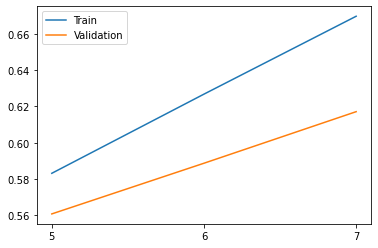

In [155]:
plt.plot(depths, train_score, label='Train')
plt.plot(depths, test_score, label = 'Validation')
plt.xticks(depths)
plt.legend()
plt.show()

In [160]:
# restart model
RandomForest = RandomForestClassifier(random_state=98)

train_score = []
test_score = []
estimators = [50,60,70]
for estimator in estimators:
    RandomForest = RandomForest.set_params(max_depth=7, n_estimators=estimator).fit(X_process,y_train)
    train_score.append(metrics.f1_score(y_train,np.where(RandomForest.predict_proba(X_process)[:,1]>=0.155,1,0)))
    test_score.append(metrics.f1_score(y_test,np.where(RandomForest.predict_proba(X_test)[:,1]>=0.155,1,0)))

In [161]:
test_score

[0.6222222222222222, 0.619324796274738, 0.6123853211009175]

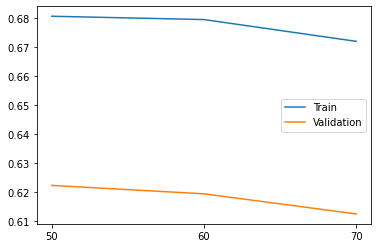

In [162]:
plt.plot(estimators, train_score, label='Train')
plt.plot(estimators, test_score, label = 'Validation')
plt.xticks(estimators)
plt.legend()
plt.show()

In [163]:
# restart model
RandomForest = RandomForestClassifier(random_state=98)

train_score = []
test_score = []
sizes = [0.1,0.2,0.5,1]
for size in sizes:
    RandomForest = RandomForest.set_params(max_depth=6, n_estimators=45, min_samples_leaf=size).fit(X_process,y_train)
    train_score.append(metrics.f1_score(y_train,np.where(RandomForest.predict_proba(X_process)[:,1]>=0.155,1,0)))
    test_score.append(metrics.f1_score(y_test,np.where(RandomForest.predict_proba(X_test)[:,1]>=0.155,1,0)))

In [164]:
test_score

[0.47168216398985624, 0.3760299625468164, 0.0, 0.5678233438485804]

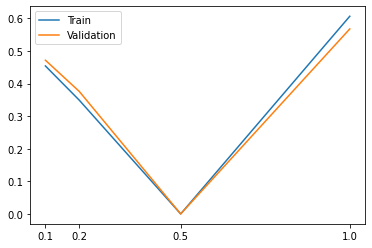

In [165]:
plt.plot(sizes, train_score, label='Train')
plt.plot(sizes, test_score, label = 'Validation')
plt.xticks(sizes)
plt.legend()
plt.show()

In [166]:
RandomForest = RandomForestClassifier(max_depth=7, n_estimators=50,random_state=98).fit(X_process,y_train)

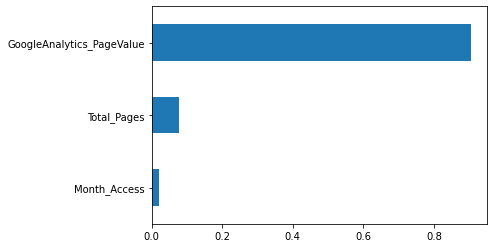

In [167]:
rf_featimp = pd.Series(RandomForest.feature_importances_, index=X_process.columns)
rf_featimp = dt_featimp[rf_featimp>=0.001]
rf_featimp.sort_values().plot(kind='barh')
plt.show()

In [111]:
#rf_params = {'n_estimators': (1300,1400), 'max_depth': (30,35), 'max_samples': (None,0.9)}

In [112]:
#rf_Grid = GridSearchCV(RandomForest, rf_params, scoring='f1', cv=4).fit(X_train,y_train)

In [113]:
#rf_Grid.cv_results_

In [190]:
estimator = RandomForest.estimators_[2]

In [191]:
estimator

DecisionTreeClassifier(max_depth=6, max_features='auto', random_state=972178737)

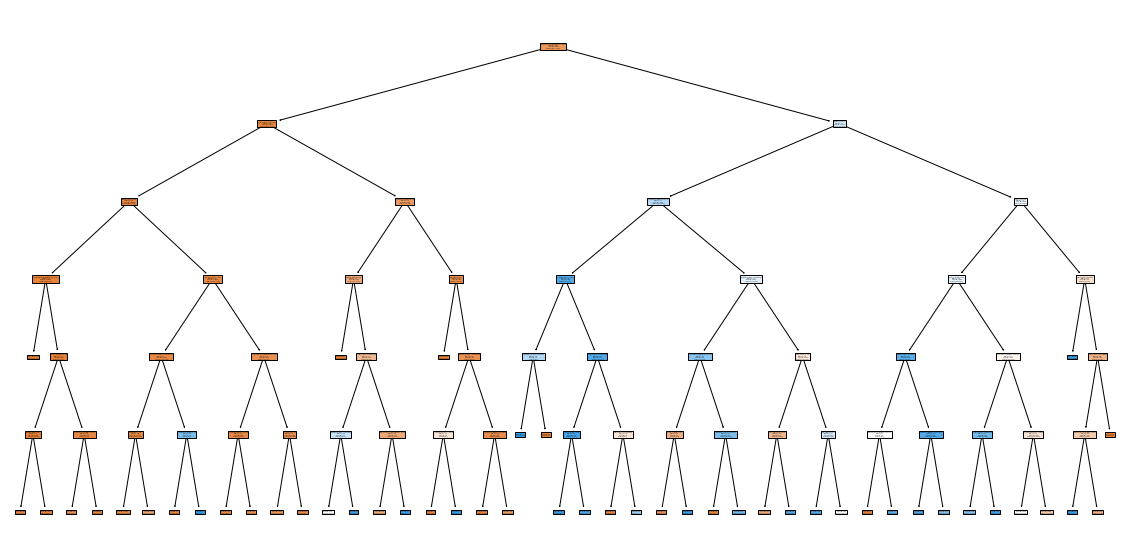

In [192]:
fig = plt.figure(figsize=(20,10))
tree.plot_tree(estimator, feature_names=X_process.columns, filled=True)
plt.show()

In [215]:
RF_train_class = np.where(RandomForest.predict_proba(X_process)[:,1]>=0.375,1,0)
RF_test_class = np.where(RandomForest.predict_proba(X_test)[:,1]>=0.375,1,0)

In [216]:
print('------ Train metrics' + '\n')
print('Precision: '+ str(round(metrics.precision_score(y_train, RF_train_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_train, RF_train_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_train, RF_train_class),3)))

print('\n')
print('------ Validation metrics' + '\n')

print('Precision: '+ str(round(metrics.precision_score(y_test, RF_test_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_test, RF_test_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_test, RF_test_class),3)))


------ Train metrics

Precision: 0.749
Recall: 0.744
F1 Score: 0.746


------ Validation metrics

Precision: 0.665
Recall: 0.671
F1 Score: 0.668


In [217]:
pd.crosstab(RF_test_class,y_test)

Buy,0,1
row_0,,
0,1585,102
1,105,208


In [270]:
model_metrics.loc['Random Forest','Precision'] = round(metrics.precision_score(y_test, RF_test_class),3)
model_metrics.loc['Random Forest','Recall'] = round(metrics.recall_score(y_test, RF_test_class),3)
model_metrics.loc['Random Forest','F1 Score'] = round(metrics.f1_score(y_test, RF_test_class),3)

In [271]:
model_metrics

,Precision,Recall,F1 Score
Decision Tree,0.571,0.794,0.664
Random Forest,0.665,0.671,0.668


In [220]:
## Gradient Boosting
GradientBoost = GradientBoostingClassifier(random_state=101)

In [221]:
train_score = []
test_score = []
depths = [2,3,4,5,6,7]
for depth in depths:
    GradientBoost = GradientBoost.set_params(max_depth=depth).fit(X_process,y_train)
    train_score.append(metrics.f1_score(y_train,np.where(GradientBoost.predict_proba(X_process)[:,1]>=0.155,1,0)))
    test_score.append(metrics.f1_score(y_test,np.where(GradientBoost.predict_proba(X_test)[:,1]>=0.155,1,0)))

In [222]:
test_score

[0.6692209450830141,
 0.6607818411097099,
 0.6581956797966964,
 0.6581956797966964,
 0.6606451612903225,
 0.668421052631579]

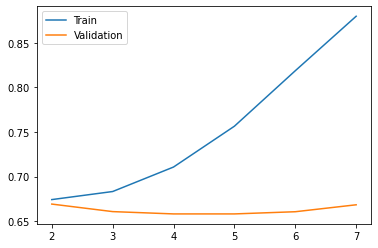

In [223]:
plt.plot(depths, train_score, label='Train')
plt.plot(depths, test_score, label = 'Validation')
plt.xticks(depths)
plt.legend()
plt.show()

In [228]:
# number of estimators
GradientBoost = GradientBoostingClassifier(random_state=101)

train_score = []
test_score = []

estimators = [80,90,100]
for estimator in estimators:
    GradientBoost = GradientBoost.set_params(max_depth=2, n_estimators=estimator).fit(X_process,y_train)
    train_score.append(metrics.f1_score(y_train,np.where(GradientBoost.predict_proba(X_process)[:,1]>=0.155,1,0)))
    test_score.append(metrics.f1_score(y_test,np.where(GradientBoost.predict_proba(X_test)[:,1]>=0.155,1,0)))

In [229]:
test_score

[0.6666666666666667, 0.6658195679796697, 0.6692209450830141]

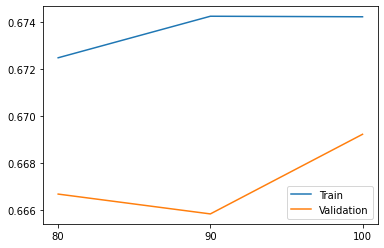

In [230]:
plt.plot(estimators, train_score, label='Train')
plt.plot(estimators, test_score, label = 'Validation')
plt.xticks(estimators)
plt.legend()
plt.show()

In [232]:
#learning rate
GradientBoost = GradientBoostingClassifier(random_state=101)

train_score = []
test_score = []

rates = [0.01, 0.05, 0.1]

for rate in rates:
    GradientBoost = GradientBoost.set_params(max_depth=2, n_estimators=100, learning_rate=rate).fit(X_process,y_train)
    train_score.append(metrics.f1_score(y_train,np.where(GradientBoost.predict_proba(X_process)[:,1]>=0.155,1,0)))
    test_score.append(metrics.f1_score(y_test,np.where(GradientBoost.predict_proba(X_test)[:,1]>=0.155,1,0)))


In [237]:
test_score

[0.6411837237977804, 0.6590909090909091, 0.6692406692406693]

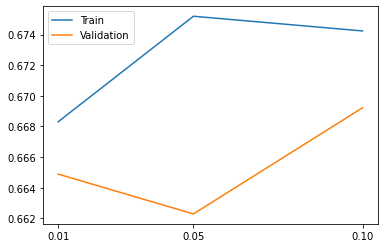

In [233]:
plt.plot(rates, train_score, label='Train')
plt.plot(rates, test_score, label = 'Validation')
plt.xticks(rates)
plt.legend()
plt.show()

In [234]:
GradientBoost = GradientBoostingClassifier(max_depth=2, n_estimators=100, learning_rate=0.1,random_state=101).fit(X_process,y_train)

In [197]:
#GradientBoost.estimators_

In [240]:
estimator = GradientBoost.estimators_[0][0]

In [241]:
type(estimator)

sklearn.tree._classes.DecisionTreeRegressor

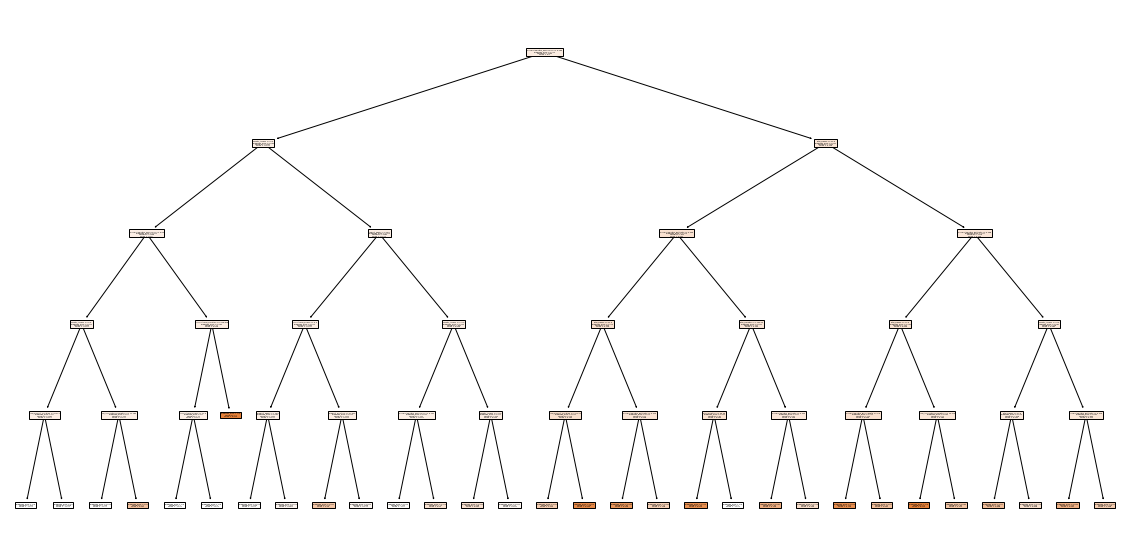

In [242]:
fig = plt.figure(figsize=(20,10))
tree.plot_tree(estimator, feature_names=X_process.columns, filled=True)
plt.show()

In [122]:
#scores = cross_val_score(GradientBoost1, X_train, y, cv=5, scoring='f1')
# print(scores)
# print("%0.2f f1_score with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

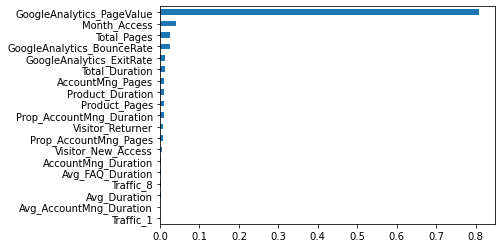

In [235]:
GB_feat_imprt = pd.Series(GradientBoost.feature_importances_, index=X_process.columns).sort_values()
GB_feat_imprt[GB_feat_imprt>0.001].plot(kind='barh')
plt.show()

In [416]:
GB_feat_imprt[GB_feat_imprt>0.001].sort_values(ascending=False)

GoogleAnalytics_PageValue     0.807997
Month_Access                  0.040051
Total_Pages                   0.024684
GoogleAnalytics_BounceRate    0.024638
GoogleAnalytics_ExitRate      0.013797
Total_Duration                0.011681
AccountMng_Pages              0.011330
Product_Duration              0.010520
Product_Pages                 0.009990
Prop_AccountMng_Duration      0.009629
Visitor_Returner              0.008895
Prop_AccountMng_Pages         0.006735
Visitor_New_Access            0.004270
AccountMng_Duration           0.003849
Avg_FAQ_Duration              0.002547
Traffic_8                     0.002293
Avg_Duration                  0.001896
Avg_AccountMng_Duration       0.001169
Traffic_1                     0.001094
dtype: float64

In [266]:
GB_train_class = np.where(GradientBoost.predict_proba(X_process)[:,1]>=0.313,1,0)
GB_test_class = np.where(GradientBoost.predict_proba(X_test)[:,1]>=0.313,1,0)

In [267]:
print('------ Train metrics' + '\n')
print('Precision: '+ str(round(metrics.precision_score(y_train, GB_train_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_train, GB_train_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_train, GB_train_class),3)))

print('\n')
print('------ Validation metrics' + '\n')

print('Precision: '+ str(round(metrics.precision_score(y_test, GB_test_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_test, GB_test_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_test, GB_test_class),3)))

------ Train metrics

Precision: 0.646
Recall: 0.778
F1 Score: 0.706


------ Validation metrics

Precision: 0.621
Recall: 0.739
F1 Score: 0.675


In [272]:
model_metrics.loc['Gradient Boost','Precision'] = round(metrics.precision_score(y_test, GB_test_class),3)
model_metrics.loc['Gradient Boost','Recall'] = round(metrics.recall_score(y_test, GB_test_class),3)
model_metrics.loc['Gradient Boost','F1 Score'] = round(metrics.f1_score(y_test, GB_test_class),3)

In [273]:
model_metrics

,Precision,Recall,F1 Score
Decision Tree,0.571,0.794,0.664
Random Forest,0.665,0.671,0.668
Gradient Boost,0.621,0.739,0.675


### Linear Models

In [423]:
## scaling data for regularization

# training
X_scaled = X_process.copy()
scaler = StandardScaler().fit(X_process)
scaled = scaler.transform(X_process)
X_scaled[X_process.columns] = scaled

# validation
X_scaled_test=X_test.copy()
scaled_test = scaler.transform(X_scaled_test)
X_scaled_test[X_test.columns] = scaled_test

In [424]:
X_scaled.head()

,AccountMng_Pages,AccountMng_Duration,FAQ_Pages,FAQ_Duration,Product_Pages,Product_Duration,GoogleAnalytics_BounceRate,GoogleAnalytics_ExitRate,GoogleAnalytics_PageValue,Month_Access,...,Traffic_9,Traffic_10,Traffic_11,Traffic_12,Traffic_13,Traffic_14,Traffic_15,Visitor_New_Access,Visitor_Other,Visitor_Returner
Access_ID,,,,,,,,,,,,,,,,,,,,,
579558156,-0.712437,-0.594124,-0.400588,-0.277429,-0.629418,-0.678106,0.133234,0.283354,-0.349423,1.273634,...,-0.062281,-0.190902,-0.141783,-0.068252,-0.255278,-0.04953,-0.127398,-0.403913,-0.088989,0.416982
317781105,-0.712437,-0.594124,-0.400588,-0.277429,0.296814,-0.079702,-0.316080,-0.311308,-0.349423,0.979368,...,-0.062281,-0.190902,-0.141783,-0.068252,-0.255278,-0.04953,-0.127398,-0.403913,-0.088989,0.416982
607317379,-0.712437,-0.594124,-0.400588,-0.277429,-0.432945,-0.508130,-0.161499,-0.401845,-0.349423,-1.374754,...,-0.062281,-0.190902,-0.141783,-0.068252,-0.255278,-0.04953,-0.127398,-0.403913,-0.088989,0.416982
474356679,-0.387655,-0.533657,-0.400588,-0.277429,-0.545215,-0.404361,-0.456233,-0.739300,0.151443,1.273634,...,-0.062281,-0.190902,-0.141783,-0.068252,-0.255278,-0.04953,-0.127398,2.475778,-0.088989,-2.398188
487584836,-0.712437,-0.594124,-0.400588,-0.277429,-0.713621,-0.242920,0.574303,0.651674,-0.349423,0.685103,...,-0.062281,-0.190902,-0.141783,-0.068252,-0.255278,-0.04953,-0.127398,-0.403913,-0.088989,0.416982


In [427]:
LogRegress = LogisticRegression(max_iter=900, solver='saga', penalty='elasticnet', l1_ratio=0.8).fit(X_scaled,y_train)

In [428]:
LogRegress.coef_

array([[-2.26500486e-01,  5.98836523e-02, -5.54725005e-02,
         1.06888682e-01,  6.54179019e-02,  1.46046929e-01,
         7.56893107e-03, -7.17640408e-01,  1.36032292e+00,
         2.69959874e-01,  7.20031060e-02,  3.29061029e-02,
         1.55286501e-01,  2.13532209e-01, -2.15335686e-02,
        -1.22141671e-01, -5.60975959e-02,  2.17437264e-02,
         3.59174290e-02,  7.76584022e-04, -6.83452909e-02,
        -2.03719417e-02, -9.61753950e-02,  5.43917839e-03,
        -8.56207341e-02, -1.34374420e-02, -4.75782214e-02,
        -3.55939419e-02,  5.19758589e-02,  0.00000000e+00,
        -1.34278138e-02,  0.00000000e+00, -7.08290284e-03,
        -1.59913645e-01,  4.62917949e-02,  4.73536851e-02,
        -5.88288959e-02, -3.63565532e-02,  0.00000000e+00,
         3.65809988e-02, -1.34374420e-02,  4.19216580e-02,
        -2.80731490e-02,  0.00000000e+00,  1.19152968e-02,
        -2.81604781e-02,  0.00000000e+00,  2.26868208e-02,
        -2.34114465e-02,  1.21327547e-02, -1.82205881e-0

In [445]:
## predict class
LR_train_class = np.where(LogRegress.predict_proba(X_scaled)[:,1]>=0.2,1,0)
LR_test_class = np.where(LogRegress.predict_proba(X_scaled_test)[:,1]>=0.2,1,0)

In [446]:
print('------ Train metrics' + '\n')
print('Precision: '+ str(round(metrics.precision_score(y_train, LR_train_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_train, LR_train_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_train, LR_train_class),3)))

print('\n')
print('------ Validation metrics' + '\n')

print('Precision: '+ str(round(metrics.precision_score(y_test, LR_test_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_test, LR_test_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_test, LR_test_class),3)))

------ Train metrics

Precision: 0.582
Recall: 0.7
F1 Score: 0.635


------ Validation metrics

Precision: 0.574
Recall: 0.677
F1 Score: 0.621


In [447]:
model_metrics.loc['Logistic Regression','Precision'] = round(metrics.precision_score(y_test, LR_test_class),3)
model_metrics.loc['Logistic Regression','Recall'] = round(metrics.recall_score(y_test, LR_test_class),3)
model_metrics.loc['Logistic Regression','F1 Score'] = round(metrics.f1_score(y_test, LR_test_class),3)

In [448]:
model_metrics

,Precision,Recall,F1 Score
Decision Tree,0.571,0.794,0.664
Random Forest,0.665,0.671,0.668
Gradient Boost,0.621,0.739,0.675
Logistic Regression,0.574,0.677,0.621


In [449]:
RidgeClass = RidgeClassifier(class_weight='balanced', alpha=5).fit(X_scaled,y_train)

In [450]:
RidgeClass.coef_

array([[-0.04778593,  0.03123605, -0.0076954 ,  0.03903142,  0.02509758,
         0.05595174,  0.09946444, -0.27342076,  0.29754234,  0.09970105,
         0.01876153,  0.01973584,  0.05828172,  0.13594239,  0.0151519 ,
         0.00317968, -0.06474923, -0.01988583, -0.03942528,  0.00538996,
        -0.0143772 ,  0.00295538, -0.03027778, -0.00462093, -0.01122368,
        -0.00426059, -0.01131476, -0.00697175,  0.01266137,  0.0107387 ,
         0.00332303,  0.01104218, -0.00582294, -0.03524486,  0.02009534,
         0.00943763, -0.02944654, -0.01317515, -0.01252128,  0.01271722,
        -0.00426059,  0.01965636, -0.01853982,  0.00095201,  0.00584909,
        -0.00566561, -0.00520442,  0.00692942, -0.00529077,  0.00748433,
        -0.00388666, -0.00596656, -0.00803749,  0.02719977, -0.03696252,
         0.00086006,  0.01980212, -0.00660619,  0.00221911,  0.04448615,
        -0.00772185,  0.01238648,  0.03215578, -0.03025989, -0.04512493,
        -0.0056692 ,  0.0169388 ,  0.00953557, -0.0

In [451]:
# RG_train_class = np.where(RidgeClass.predict_proba(X_scaled)[:,1]>=y_train.mean(),1,0)
# RG_test_class = np.where(RidgeClass.predict_proba(X_scaled_test)[:,1]>=y_train.mean(),1,0)
RG_train_class = RidgeClass.predict(X_scaled)
RG_test_class = RidgeClass.predict(X_scaled_test)

In [452]:
print('------ Train metrics' + '\n')
print('Precision: '+ str(round(metrics.precision_score(y_train, RG_train_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_train, RG_train_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_train, RG_train_class),3)))

print('\n')
print('------ Validation metrics' + '\n')

print('Precision: '+ str(round(metrics.precision_score(y_test, RG_test_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_test, RG_test_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_test, RG_test_class),3)))

------ Train metrics

Precision: 0.463
Recall: 0.741
F1 Score: 0.57


------ Validation metrics

Precision: 0.456
Recall: 0.7
F1 Score: 0.552


In [456]:
# keep only the most important features from the trees
X_scaled = X_scaled[GB_feat_imprt[GB_feat_imprt>0.001].index]
X_scaled_test = X_scaled_test[GB_feat_imprt[GB_feat_imprt>0.001].index]

In [475]:
# number of neighboors
neigh = KNeighborsClassifier()

train_score = []
test_score = []

neighbors = [100,150,200,250,300]

for nei in neighbors:
    neigh = neigh.set_params(n_neighbors=nei).fit(X_scaled,y_train)
    train_score.append(metrics.f1_score(y_train,np.where(neigh.predict_proba(X_scaled)[:,1]>=0.155,1,0)))
    test_score.append(metrics.f1_score(y_test,np.where(neigh.predict_proba(X_scaled_test)[:,1]>=0.155,1,0)))

In [477]:
test_score

[0.5379310344827586,
 0.5318181818181819,
 0.5213483146067416,
 0.5370370370370371,
 0.5341176470588236]

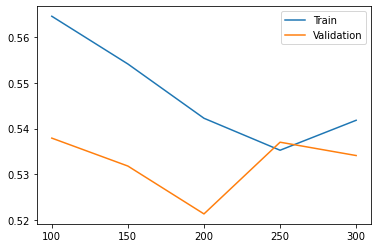

In [476]:
plt.plot(neighbors, train_score, label='Train')
plt.plot(neighbors, test_score, label = 'Validation')
plt.xticks(neighbors)
plt.legend()
plt.show()

In [491]:
# number of neighboors
neigh = KNeighborsClassifier()

train_score = []
test_score = []

distances = ['euclidean','mahalanobis','minkowski']

for dist in distances:
    neigh = neigh.set_params(n_neighbors=250, metric=dist).fit(X_scaled,y_train) 
    train_score.append(metrics.f1_score(y_train,np.where(neigh.predict_proba(X_scaled)[:,1]>=0.155,1,0)))
    test_score.append(metrics.f1_score(y_test,np.where(neigh.predict_proba(X_scaled_test)[:,1]>=0.155,1,0)))


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1462: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\pairwise.py:1462: FutureWarning: from version 1.0 (renaming of 0.25), pairwise_distances for metric='mahalanobis' will require VI to be specified if Y is passed.
  warnings.warn(


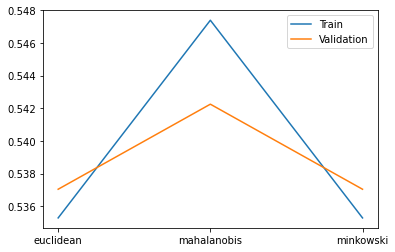

In [492]:
plt.plot(distances, train_score, label='Train')
plt.plot(distances, test_score, label = 'Validation')
plt.xticks(distances)
plt.legend()
plt.show()

In [496]:
# KKN
neigh = KNeighborsClassifier(n_neighbors=250).fit(X_scaled, y_train)

In [497]:
Knn_train_class = np.where(neigh.predict_proba(X_scaled)[:,1]>=0.2,1,0)
Knn_test_class = np.where(neigh.predict_proba(X_scaled_test)[:,1]>=0.2,1,0)

In [498]:
print('------ Train metrics' + '\n')
print('Precision: '+ str(round(metrics.precision_score(y_train, Knn_train_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_train, Knn_train_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_train, Knn_train_class),3)))

print('\n')
print('------ Validation metrics' + '\n')

print('Precision: '+ str(round(metrics.precision_score(y_test, Knn_test_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_test, Knn_test_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_test, Knn_test_class),3)))

------ Train metrics

Precision: 0.528
Recall: 0.639
F1 Score: 0.578


------ Validation metrics

Precision: 0.508
Recall: 0.642
F1 Score: 0.567


In [481]:
model_metrics.loc['K-N Neighbors','Precision'] = round(metrics.precision_score(y_test, Knn_test_class),3)
model_metrics.loc['K-N Neighbors','Recall'] = round(metrics.recall_score(y_test, Knn_test_class),3)
model_metrics.loc['K-N Neighbors','F1 Score'] = round(metrics.f1_score(y_test, Knn_test_class),3)

In [482]:
model_metrics

,Precision,Recall,F1 Score
Decision Tree,0.571,0.794,0.664
Random Forest,0.665,0.671,0.668
Gradient Boost,0.621,0.739,0.675
Logistic Regression,0.574,0.677,0.621
K-N Neighbors,0.508,0.642,0.567


In [ ]:
## Support Vector Machines

In [501]:
scv = SVC(gamma='auto', probability=True).fit(X_scaled, y_train)

In [534]:
Svc_train_class = np.where(scv.predict_proba(X_scaled)[:,1]>=0.16,1,0)
Svc_test_class = np.where(scv.predict_proba(X_scaled_test)[:,1]>=0.16,1,0)

In [535]:
print('------ Train metrics' + '\n')
print('Precision: '+ str(round(metrics.precision_score(y_train, Svc_train_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_train, Svc_train_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_train, Svc_train_class),3)))

print('\n')
print('------ Validation metrics' + '\n')

print('Precision: '+ str(round(metrics.precision_score(y_test, Svc_test_class),3)))
print('Recall: '+ str(round(metrics.recall_score(y_test, Svc_test_class),3)))
print('F1 Score: '+ str(round(metrics.f1_score(y_test, Svc_test_class),3)))

------ Train metrics

Precision: 0.718
Recall: 0.673
F1 Score: 0.695


------ Validation metrics

Precision: 0.648
Recall: 0.6
F1 Score: 0.623


In [536]:
model_metrics.loc['Support VC','Precision'] = round(metrics.precision_score(y_test, Svc_test_class),3)
model_metrics.loc['Support VC','Recall'] = round(metrics.recall_score(y_test, Svc_test_class),3)
model_metrics.loc['Support VC','F1 Score'] = round(metrics.f1_score(y_test, Svc_test_class),3)

In [537]:
model_metrics

,Precision,Recall,F1 Score
Decision Tree,0.571,0.794,0.664
Random Forest,0.665,0.671,0.668
Gradient Boost,0.621,0.739,0.675
Logistic Regression,0.574,0.677,0.621
K-N Neighbors,0.508,0.642,0.567
Support VC,0.648,0.6,0.623


### Submission 

In [274]:
## prepair test data
#df_test = pd.read_csv('../data/test.csv')
# set access ID as index
df_test.set_index('Access_ID', inplace = True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2300 entries, 798519314 to 962218682
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        2300 non-null   object 
 1   AccountMng_Pages            2300 non-null   int64  
 2   AccountMng_Duration         2300 non-null   float64
 3   FAQ_Pages                   2300 non-null   int64  
 4   FAQ_Duration                2300 non-null   float64
 5   Product_Pages               2300 non-null   int64  
 6   Product_Duration            2300 non-null   float64
 7   GoogleAnalytics_BounceRate  2300 non-null   float64
 8   GoogleAnalytics_ExitRate    2300 non-null   float64
 9   GoogleAnalytics_PageValue   2300 non-null   float64
 10  OS                          2300 non-null   object 
 11  Browser                     2300 non-null   int64  
 12  Country                     2300 non-null   object 
 13  Type_of_Traffic     

In [275]:
df_test.isna().sum()

Date                          0
AccountMng_Pages              0
AccountMng_Duration           0
FAQ_Pages                     0
FAQ_Duration                  0
Product_Pages                 0
Product_Duration              0
GoogleAnalytics_BounceRate    0
GoogleAnalytics_ExitRate      0
GoogleAnalytics_PageValue     0
OS                            0
Browser                       0
Country                       0
Type_of_Traffic               0
Type_of_Visitor               0
dtype: int64

In [276]:
# prepares test data

# from object to date
df_test.Date = df_test.Date.apply(lambda x: datetime.datetime.strptime(x, "%d-%b-%y"))

# get details from the date
df_test['Month_Access'] = df_test.Date.apply(lambda x: x.month)
df_test['WDay_Access'] = df_test.Date.apply(lambda x: x.weekday()) ## monday is 0
#df_test['Day_Access'] = df_test.Date.apply(lambda x: x.day)

# calculate new variables

# total number of pages visited and total durantion of visits
df_test['Total_Pages'] = df_test['AccountMng_Pages']+df_test['FAQ_Pages']+df_test['Product_Pages']
df_test['Total_Duration'] = df_test['AccountMng_Duration']+df_test['FAQ_Duration']+df_test['Product_Duration']

# proportion of visits by each pages and duration
df_test['Prop_AccountMng_Pages'] = df_test['AccountMng_Pages']/df_test['Total_Pages']
df_test['Prop_FAQ_Pages'] = df_test['FAQ_Pages']/df_test['Total_Pages']
df_test['Prop_Product_Pages'] = df_test['Product_Pages']/df_test['Total_Pages']

df_test['Prop_AccountMng_Duration'] = df_test['AccountMng_Duration']/df_test['Total_Duration']
df_test['Prop_FAQ_Duration'] = df_test['FAQ_Duration']/df_test['Total_Duration']
df_test['Prop_Product_Duration'] = df_test['Product_Duration']/df_test['Total_Duration']

# averages times spent in each page
df_test['Avg_AccountMng_Duration'] = df_test['AccountMng_Duration']/df_test['AccountMng_Pages']
df_test['Avg_FAQ_Duration'] = df_test['FAQ_Duration']/df_test['FAQ_Pages']
df_test['Avg_Product_Duration'] = df_test['Product_Duration']/df_test['Product_Pages']

# total average
df_test['Avg_Duration'] = df_test['Total_Duration']/df_test['Total_Pages']

# got some nans because of the division by 0
df_test.fillna(0, inplace=True)

# # create dummy varibles for value in mode for varibles with mode % > 70%

# df_test['dum_FAQ_Pages'] = np.where(df_test['FAQ_Pages']==0,1,0)
# df_test['dum_FAQ_Duration'] = np.where(df_test['FAQ_Duration']==0,1,0)
# df_test['dum_GoogleAnalytics_PageValue'] = np.where(df_test['GoogleAnalytics_PageValue']==0,1,0)

# # creating dummys for the levels
# df_test['Visitor_Returner'] = np.where(df_test['Type_of_Visitor']=='Returner',1,0)
# df_test['OS_Windows'] = np.where(df_test['OS']=='Windows',1,0)
# df_test['OS_Android'] = np.where(df_test['OS']=='Android',1,0)
# df_test['OS_MacOSX'] = np.where(df_test['OS']=='MacOSX',1,0)
# df_test['Browser_1'] = np.where(df_test['Browser']==1,1,0)
# df_test['Browser_2'] = np.where(df_test['Browser']==2,1,0)
# df_test['Browser_4'] = np.where(df_test['Browser']==4,1,0)

## encoding
dummy_os = pd.get_dummies(df_test['OS'], prefix='OS')
dummy_browser = pd.get_dummies(df_test['Browser'], prefix='Browser')
dummy_country = pd.get_dummies(df_test['Country'], prefix='Country')
dummy_traffic = pd.get_dummies(df_test['Type_of_Traffic'], prefix='Traffic')
dummy_visitor = pd.get_dummies(df_test['Type_of_Visitor'], prefix='Visitor')

df_test = pd.concat([df_test, dummy_os, dummy_browser, dummy_country, dummy_traffic, dummy_visitor], axis=1)

df_test.drop(['Date','OS','Browser','Country','Type_of_Traffic','Type_of_Visitor'], axis=1, inplace=True)

df_test = df_test[X_process.columns]

In [279]:
df_test['Buy'] = np.where(GradientBoost.predict_proba(df_test)[:,1]>=0.313,1,0)

In [218]:
#df_test['Buy'] = np.where(df_test['Propensity']>0.16,1,0)

In [280]:
test_scores = df_test.copy().reset_index()

In [281]:
test_scores = test_scores[['Access_ID','Buy']]

In [282]:
test_scores

,Access_ID,Buy
0,798519314,0
1,798663101,0
2,798663221,0
3,798760918,0
4,798856982,1
...,...,...
2295,962042726,0
2296,962063064,0
2297,962147749,1
2298,962182167,0


In [89]:
#sub_smp.drop('Buy', axis=1, inplace=True)

In [90]:
#submission = pd.merge(left=sub_smp, right=test_scores, on='Access_ID')

In [93]:
#submission.head()

,Access_ID,Buy
0,798519314,0
1,798663101,0
2,798663221,0
3,798760918,0
4,798856982,1


In [283]:
test_scores.to_csv('../submission5.csv', index=False)